## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
import ast
import boto3
import missingno as msno
from mpl_toolkits.basemap import Basemap #For Geoplot visualizations.
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

E:\Softwares\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading Data from S3 

In [2]:
df_train_mobile = pd.read_csv('https://uoacapstone.s3.amazonaws.com/train_mobile_brand.csv') #Reading the Mobile Brand data
df_train_event= pd.read_csv('https://uoacapstone.s3.amazonaws.com/train_event_data.csv') #Reading the Train Event Data
df_app_events = pd.read_csv('https://uoacapstone.s3.amazonaws.com/app_events.csv')#Reading the App Events Data
df_app_events_meta = pd.read_csv('https://uoacapstone.s3.amazonaws.com/app_events_meta_data.csv',engine='python',skiprows = 1,error_bad_lines=False)#Reading the App Events Meta Data

Skipping line 415401: ',' expected after '"'
Skipping line 415402: ',' expected after '"'
Skipping line 415403: ',' expected after '"'
Skipping line 415404: ',' expected after '"'
Skipping line 415405: ',' expected after '"'
Skipping line 415406: ',' expected after '"'
Skipping line 415407: ',' expected after '"'
Skipping line 415408: ',' expected after '"'
Skipping line 415409: ',' expected after '"'
Skipping line 415410: ',' expected after '"'
Skipping line 415411: ',' expected after '"'
Skipping line 415412: ',' expected after '"'
Skipping line 415413: ',' expected after '"'
Skipping line 415414: ',' expected after '"'
Skipping line 415415: ',' expected after '"'
Skipping line 415416: ',' expected after '"'
Skipping line 415417: ',' expected after '"'
Skipping line 415418: ',' expected after '"'
Skipping line 415419: ',' expected after '"'
Skipping line 415420: ',' expected after '"'
Skipping line 416256: ',' expected after '"'
Skipping line 416257: ',' expected after '"'
Skipping l

There are some rows in app_events_data where quotes are incorrectly placed like below  on line 415401 <br>
9.16E+18,931,"Hong Kong

In [3]:
df_train_mobile.head()#Glimpse of data

device_id gender  age group_train phone_brand device_model
0 -7548291590301750000      M   33        M32+      Huawei     è£è€€3C
1  6943568600617760000      M   37        M32+      Xiaomi        xnote
2  5441349705980020000      M   40        M32+        OPPO          R7s
3 -5393876656119450000      M   33        M32+      Xiaomi         MI 4
4  4543988487649880000      M   53        M32+     samsung    Galaxy S4

In [4]:
df_train_event.head()#Glimpse of data

device_id gender  age group_train   event_id  \
0 -7548291590301750000      M   33        M32+  2369465.0   
1 -7548291590301750000      M   33        M32+  1080869.0   
2 -7548291590301750000      M   33        M32+  1079338.0   
3 -7548291590301750000      M   33        M32+  1078881.0   
4 -7548291590301750000      M   33        M32+  1068711.0   

         datetimestamp  latitude  longitude  
0  2016-05-03 15:55:35     33.98     116.79  
1  2016-05-03 06:07:16     33.98     116.79  
2  2016-05-04 03:28:02     33.98     116.79  
3  2016-05-04 02:53:08     33.98     116.79  
4  2016-05-03 15:59:35     33.98     116.79

In [5]:
df_app_events.head()#Glimpse of data

event_id               app_id  is_installed  is_active
0         2  5927333115845830913             1          1
1         2 -5720078949152207372             1          0
2         2 -1633887856876571208             1          0
3         2  -653184325010919369             1          1
4         2  8693964245073640147             1          1

In [6]:
df_app_events_meta.head()#Glimpse of data

app_id  label_id         category
0  7324884708820027918       251          Finance
1 -4494216993218550286       251          Finance
2  6058196446775239644       406          unknown
3  6058196446775239644       407  DS_P2P net loan
4  8694625920731541625       406          unknown

In [7]:
#Checking number of rows and columns
print(df_train_mobile.shape)
print(df_train_event.shape)
print(df_app_events.shape)
print(df_app_events_meta.shape)

(74840, 6)
(1266933, 8)
(32473067, 4)
(451694, 3)


## Data Cleaning

In [8]:
df_train_mobile.duplicated().value_counts() #Checking if any duplicate rows is there

False    74646
True       194
dtype: int64

In [9]:
df_train_event.duplicated().value_counts() #Checking if any duplicate rows is there

False    1266933
dtype: int64

In [10]:
df_app_events.duplicated().value_counts() #Checking if any duplicate rows is there

False    32473067
dtype: int64

In [11]:
df_app_events_meta.duplicated().value_counts() #Checking if any duplicate rows is there

False    451572
True        122
dtype: int64

- It seems train_mobile_brand and app_events_meta have duplicate rows which need to be removed.

In [12]:
#Removing duplicates from the data
df_train_mobile.drop_duplicates(inplace = True)
df_app_events_meta.drop_duplicates(inplace = True)

In [13]:
#Checking number of rows and columns
print(df_train_mobile.shape)
print(df_train_event.shape)
print(df_app_events.shape)
print(df_app_events_meta.shape)

(74646, 6)
(1266933, 8)
(32473067, 4)
(451572, 3)


## Handling Missing Values

In [14]:
#Calculating percentage of missing values for all columns
(df_train_mobile.isna().sum()/df_train_mobile.shape[0])*100 

device_id       0.0
gender          0.0
age             0.0
group_train     0.0
phone_brand     0.0
device_model    0.0
dtype: float64

In [15]:
#Calculating percentage of missing values for all columns
(df_train_event.isna().sum()/df_train_event.shape[0])*100 

device_id        0.000000
gender           0.000000
age              0.000000
group_train      0.000000
event_id         4.051911
datetimestamp    4.051911
latitude         4.051911
longitude        4.051911
dtype: float64

In [16]:
#Calculating percentage of missing values for all columns
(df_app_events.isna().sum()/df_app_events.shape[0])*100 

event_id        0.0
app_id          0.0
is_installed    0.0
is_active       0.0
dtype: float64

In [17]:
#Calculating percentage of missing values for all columns
(df_app_events_meta.isna().sum()/df_app_events.shape[0])*100 

app_id      0.0
label_id    0.0
category    0.0
dtype: float64

- In <b>train_events_data</b> `event_id`,`datetimestamp`,`latitude` and `longitude` columns semes to have missing values which is less around 4%.
- In <b>app_events_meta_data</b> `category` and `label_id` is having missing value for a minute amount of data.

<AxesSubplot:>

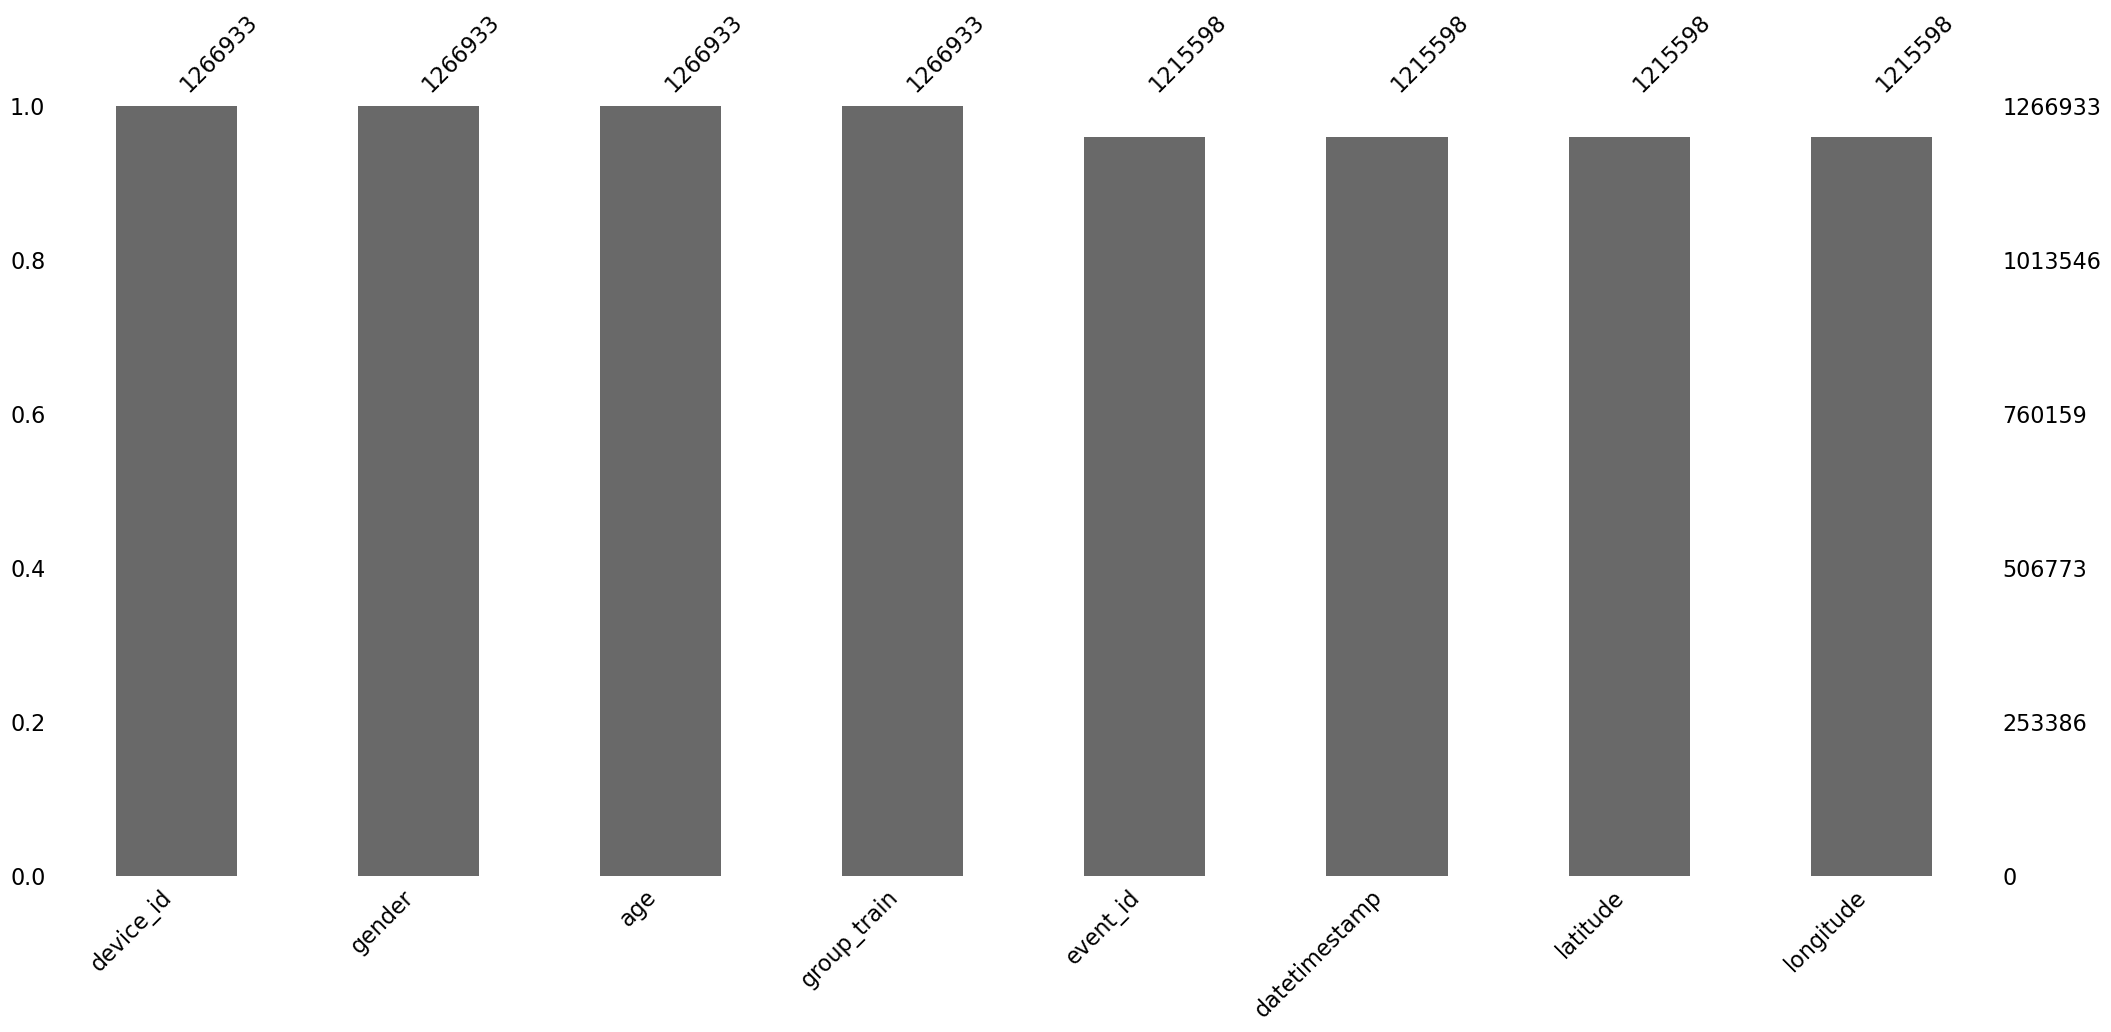

In [18]:
msno.bar(df_train_event) #Bar graph for count for missing values

<AxesSubplot:>

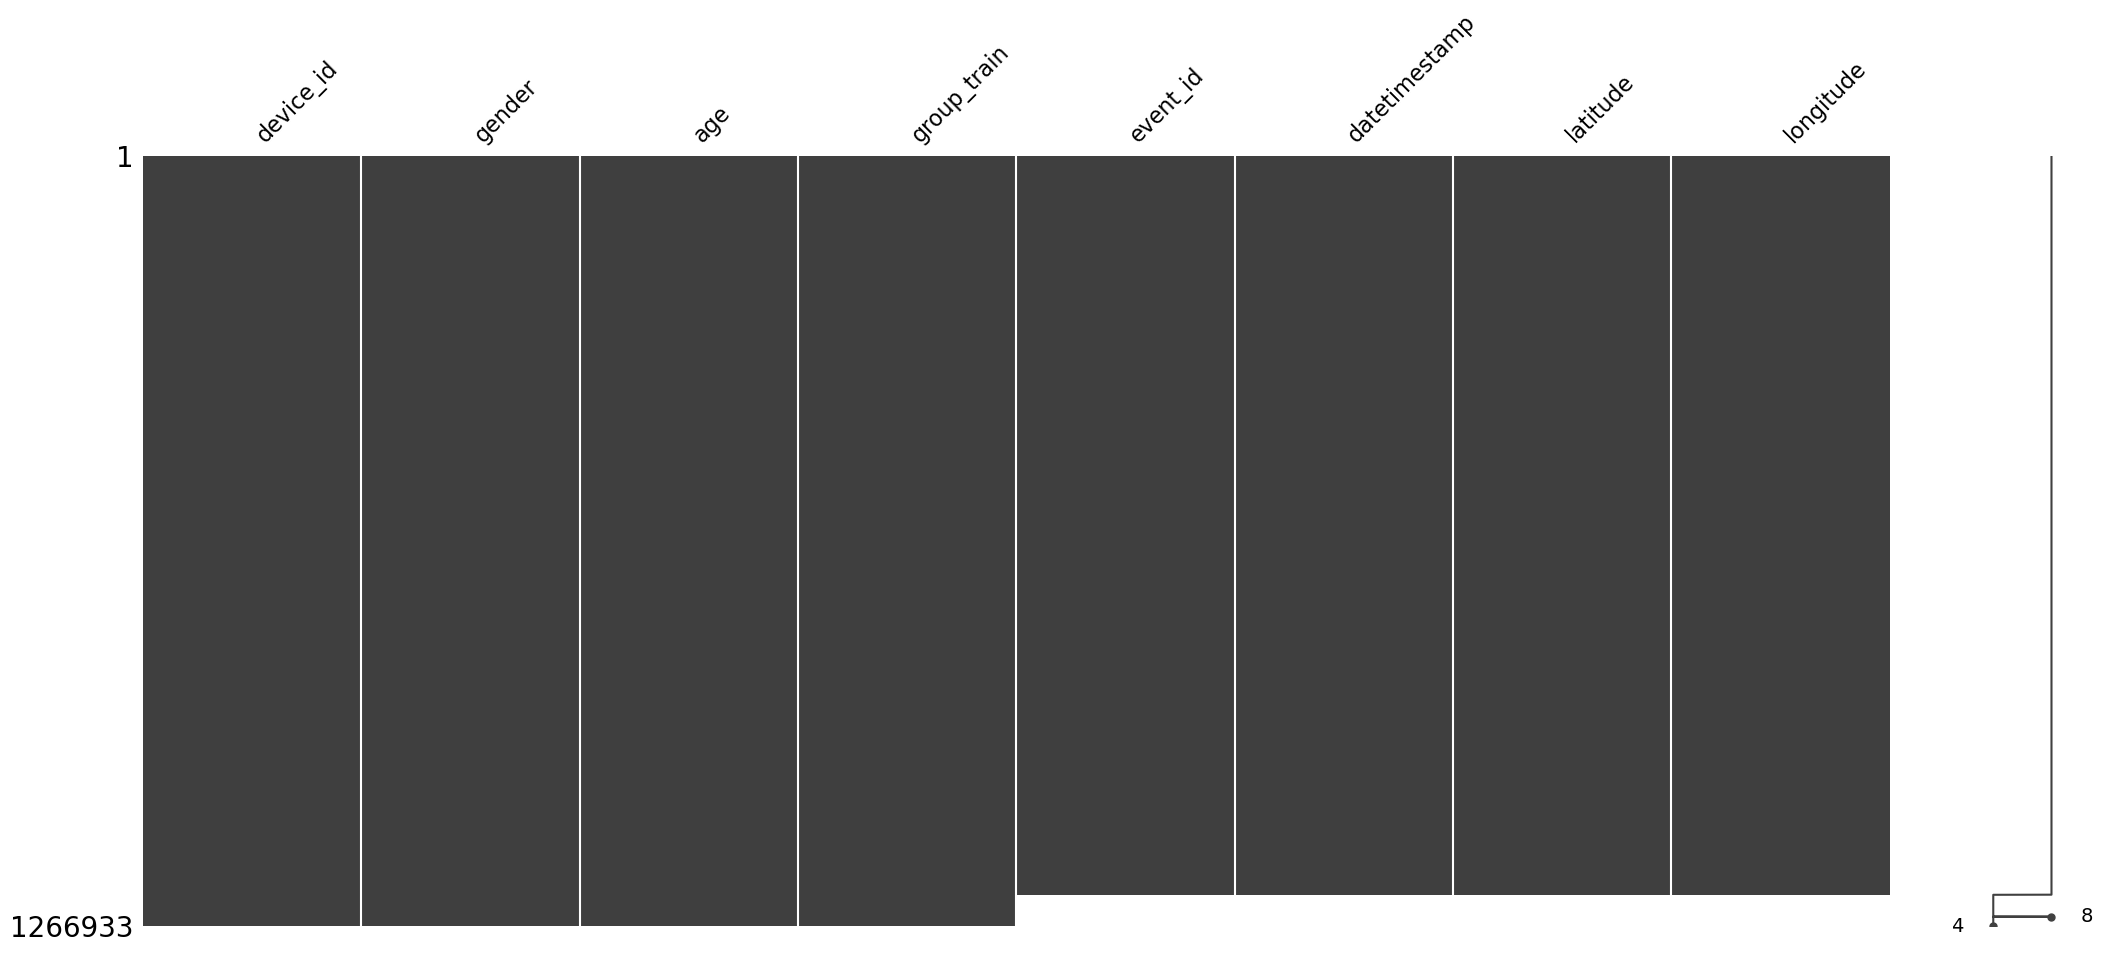

In [19]:
msno.matrix(df_train_event) #Helps in analyzing to see any pattern in missing values

- From the above plot wherever there is a grey color it indicates values are present there and wherever there is white color it indicates the values are missing.
- On the right corner there is a sparkline which will move towards right values if values are present in the columns.If missing values start to appear then it would move towards the left.
- A pattern in missing values for columns from event_id to longitude can be seen as they have similar white area and also the sparkline is to extreme left in this case.It suggests <b>values missing in these columns are somewhat related and are missing for the same rows</b>. 

<AxesSubplot:>

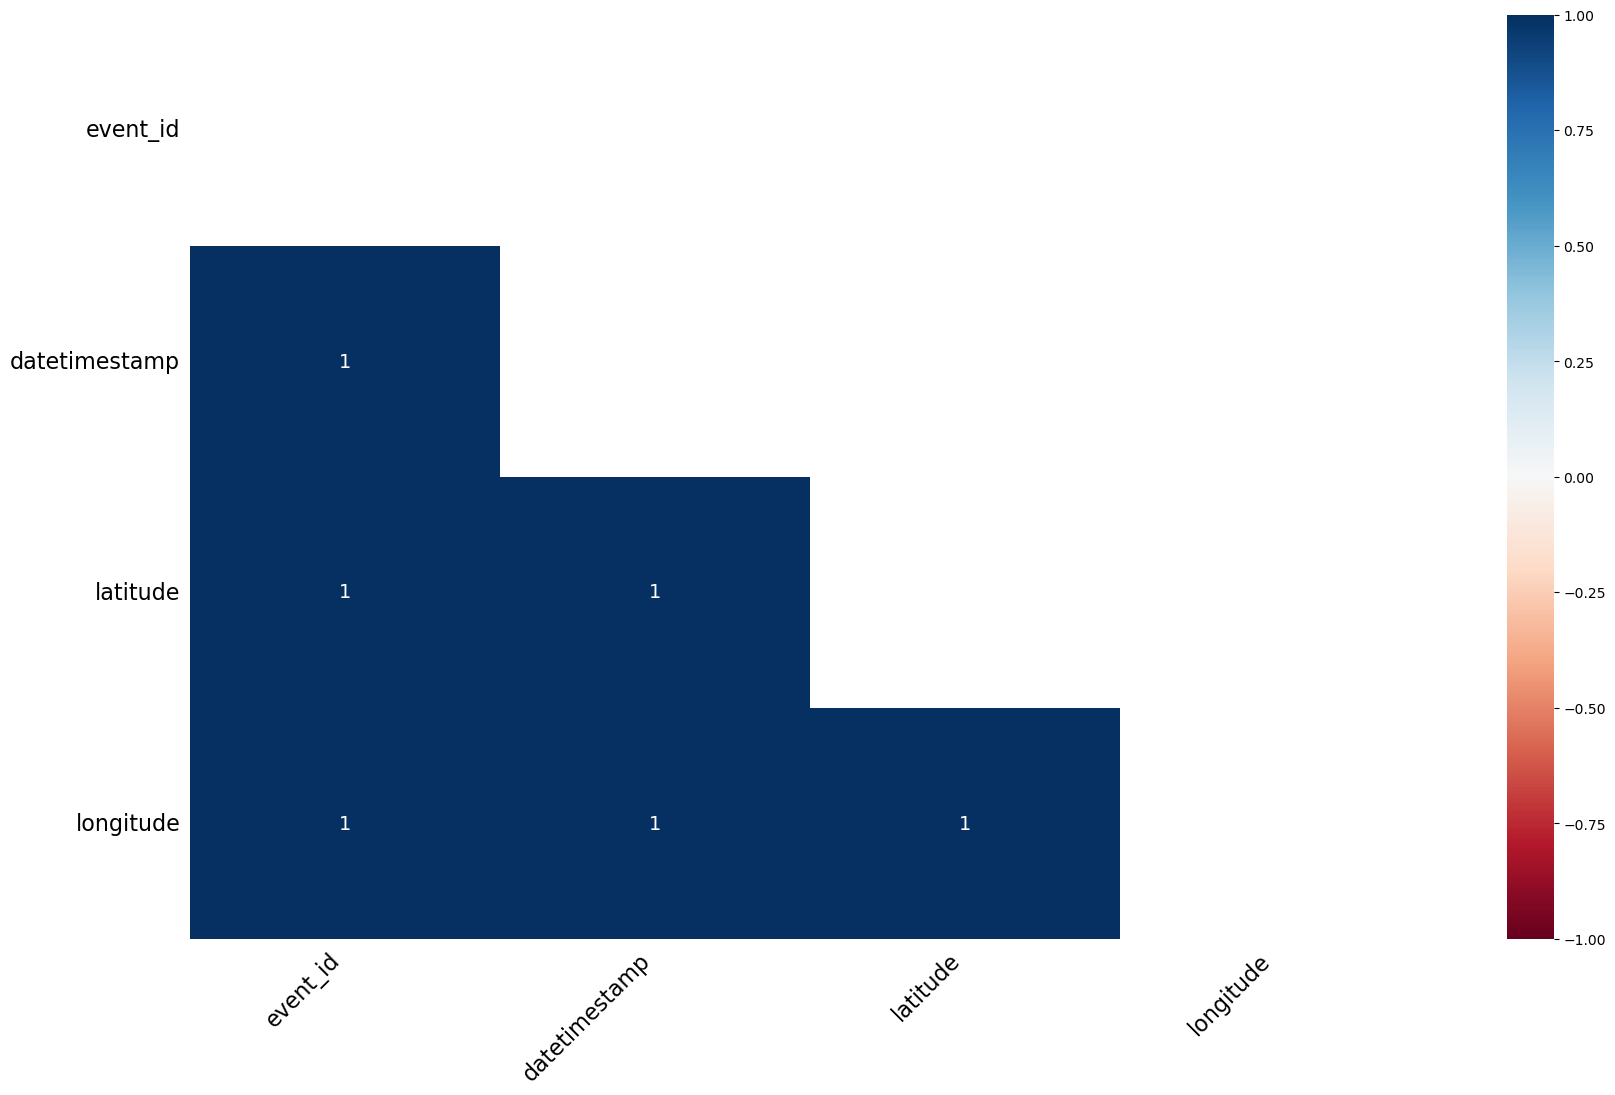

In [20]:
msno.heatmap(df_train_event) #Plotting correlation matrix for columns where values are missing

<ul>
<li>Value close to  1 indicate that the presence of null values in one column is correlated with the presence of null values in another column.</li>
<li>A value near 0 means there is no relationship between the occurrence of missing values of two variables.</li>
<li>A value near -1 means if one variable appears then for the  other variable data is very likely to be present.</li>
</ul>   
There seems to be a <b>strong positive correlation</b> of <u>missing values</u> between all the columns having missing values which indicates that for a given example if value is missing for one of the columns then all other columns having missing values are also missing.


In [21]:
df_train_event[df_train_event['event_id'].isna()] #Analyzing data where event_id is missing

device_id gender  age group_train  event_id datetimestamp  \
1215595   398514470209561000      M   68        M32+       NaN           NaN   
1215596 -3073918292047050000      M   27      M25-32       NaN           NaN   
1215597  5805880616488060000      M   39        M32+       NaN           NaN   
1215598 -2403560729305410000      M   25      M25-32       NaN           NaN   
1215599 -1889893391998300000      M   22       M0-24       NaN           NaN   
...                      ...    ...  ...         ...       ...           ...   
1266928 -8270585312108800000      F   32      F25-32       NaN           NaN   
1266929  9140950698473710000      M   41        M32+       NaN           NaN   
1266930 -5051737733034250000      M   25      M25-32       NaN           NaN   
1266931 -6901678500015010000      F   20       F0-24       NaN           NaN   
1266932  6076451050607320000      M   21       M0-24       NaN           NaN   

         latitude  longitude  
1215595       NaN        NaN  
1215596       NaN        NaN  
1215597       NaN        NaN  
1215598       NaN        NaN  
1215599       NaN        NaN  
...           ...        ...  
1266928       NaN        NaN  
1266929       NaN        NaN  
1266930       NaN        NaN  
1266931       NaN        NaN  
1266932       NaN        NaN  

[51335 rows x 8 columns]

- From the above correlation plot and looking at data some relation between missing values. It is a type of MNAR(Missing Not At Random).
- Possible reasons for missing values in train_event data.
    - No apps were used on the device hence no event was generated.
    - Location permission was not given therefore no event was generated.
    - Data collection was no accepted by the users as a privacy policy.
- As there were no events created in above case we can impute the missing values in the column to 0. While performing any operations on the data we can exclude these cases if required by filtering the event_id by 0.

<AxesSubplot:>

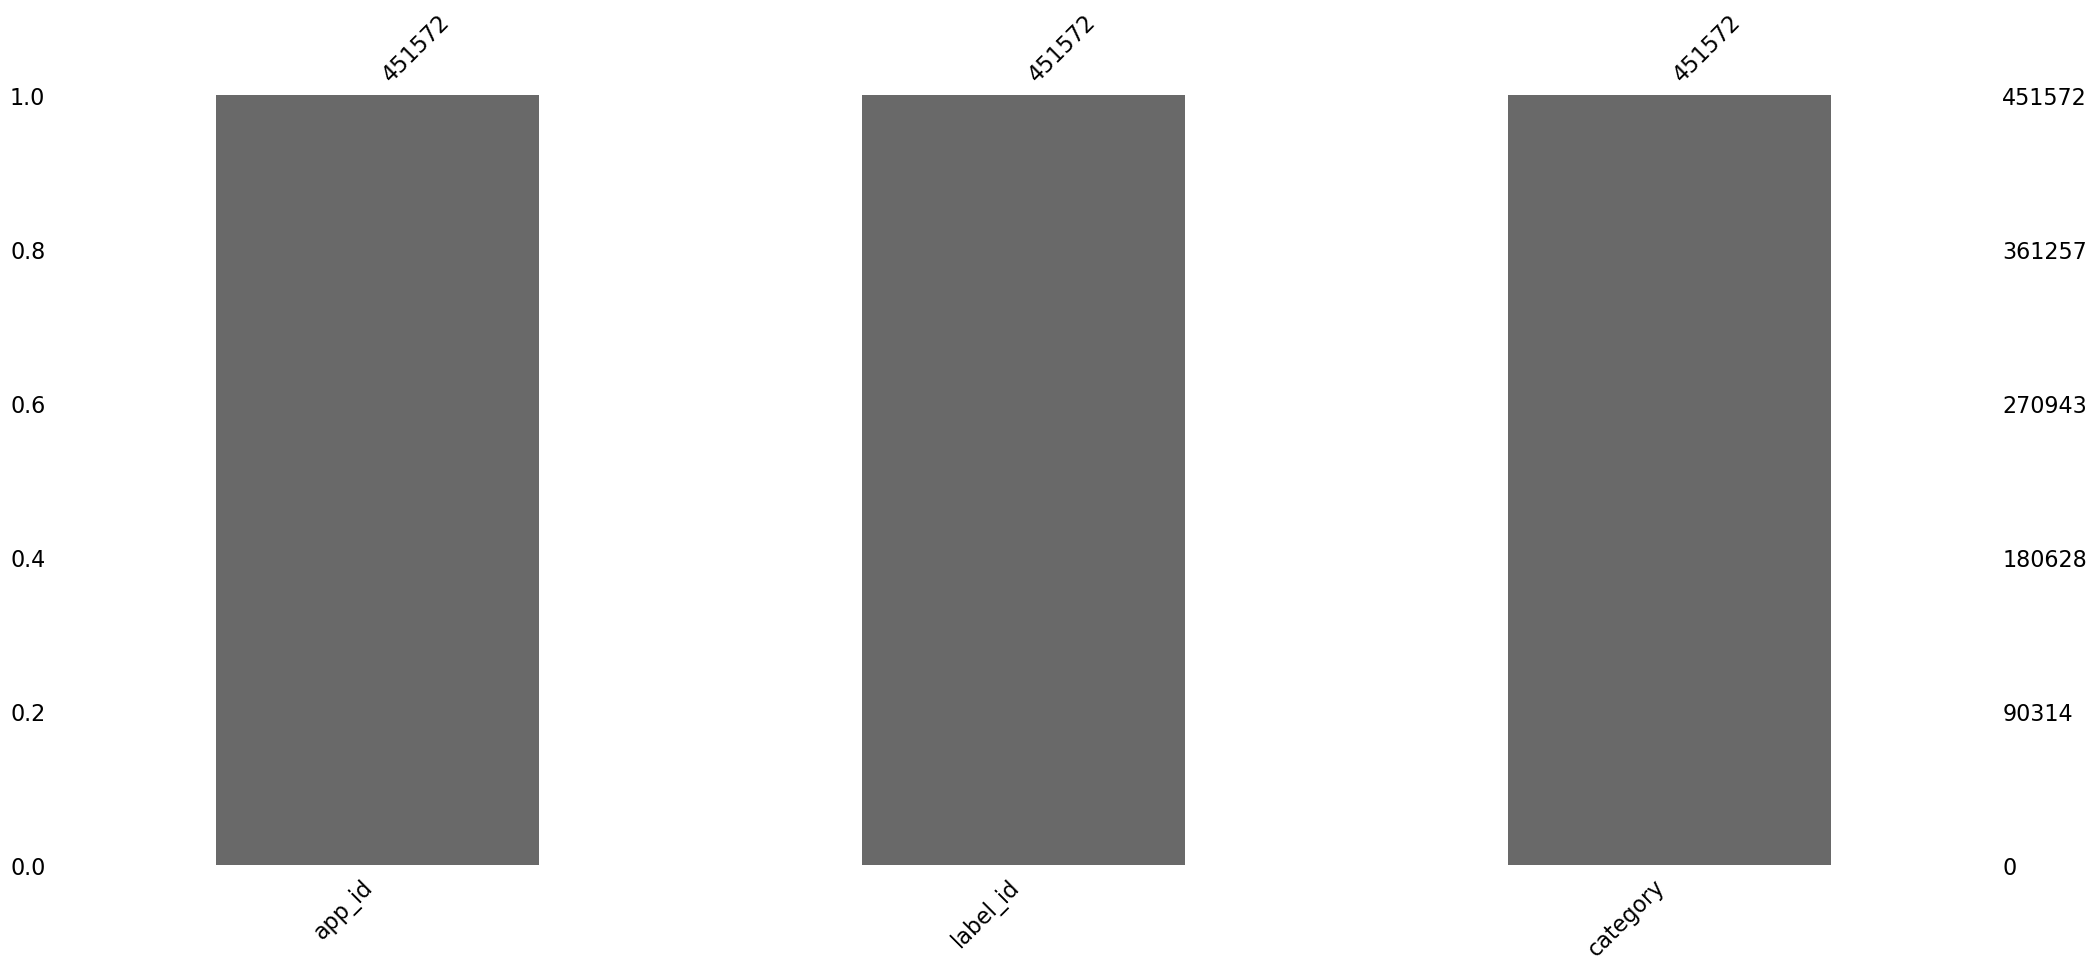

In [22]:
msno.bar(df_app_events_meta) #Bar graph for count for missing values

In [23]:
df_app_events_meta[df_app_events_meta['label_id'].isna()] #Analyzing data where Driver Id is missing

Empty DataFrame
Columns: [app_id, label_id, category]
Index: []

- Thera are only 2 records with missing values in <u>app_events_meta data</u>, they can be `removed`.

In [24]:
#Imputing missing values with 0 in train_event
df_train_event.fillna(0, inplace = True)

In [25]:
df_app_events_meta.dropna(inplace=True)#Dropping missing values for app_events_meta data

## Standardizing Values

In [26]:
df_train_mobile.dtypes #Checking for data type for all columns

device_id        int64
gender          object
age              int64
group_train     object
phone_brand     object
device_model    object
dtype: object

In [27]:
df_train_event.dtypes #Checking for data type for all columns

device_id          int64
gender            object
age                int64
group_train       object
event_id         float64
datetimestamp     object
latitude         float64
longitude        float64
dtype: object

- datetimestamp should be converted to datetime format

In [28]:
#Converting datatype of datetimestamp to datetime
df_train_event['datetimestamp'] = pd.to_datetime(df_train_event['datetimestamp'],format = '%Y/%m/%d %H:%M:%S',exact=False)

In [29]:
df_train_event['event_id'].max()

3252948.0

- It's better to represent event_id as int as the max value is 3252948 and is int range.Moreover would help in saving some memory.
- In other csv files as well it is represented as int so it's better to be consistend accross dataframes.

In [30]:
#Converting event_id to int datatype
df_train_event['event_id'] = df_train_event['event_id'].astype('int64')

In [31]:
df_app_events.dtypes #Checking for data type for all columns

event_id        int64
app_id          int64
is_installed    int64
is_active       int64
dtype: object

In [32]:
df_app_events_meta.dtypes #Checking for data type for all columns

app_id       int64
label_id     int64
category    object
dtype: object

In [33]:
df_app_events_meta['label_id'].max()

1021

- It's better to represent label_id as int as the max value is 1021 and is int range.Moreover would help in saving some memory.

In [34]:
#Converting label_id to int datatype
df_app_events_meta['label_id'] = df_app_events_meta['label_id'].astype('int64')

In [35]:
#Converting app_id to float datatype
df_app_events_meta['app_id'] = df_app_events_meta['app_id'].astype(float)
df_app_events['app_id'] = df_app_events['app_id'].astype(float)

In [36]:
df_app_events_meta['app_id'][0]

7.324884708820028e+18

In [37]:
df_train_event['event_id'].max()

3252948

In [38]:
df_train_event.dtypes  

device_id                 int64
gender                   object
age                       int64
group_train              object
event_id                  int64
datetimestamp    datetime64[ns]
latitude                float64
longitude               float64
dtype: object

- `Latitiude` values should be between -90 and +90.So it is necessary to check if in the data are there in any values outside this range.
- `Longitude` values should be between -180 and +180.So it is necessary to check if in the data are there in any values outside this range.


In [39]:
#Checking range of values for latitude
((df_train_event['latitude'] > 90) | (df_train_event['latitude'] < -90)).value_counts()

False    1266933
Name: latitude, dtype: int64

In [40]:
#Checking range of values for longitude
((df_train_event['longitude'] > 180) | (df_train_event['longitude'] < -180)).value_counts()

False    1266933
Name: longitude, dtype: int64

- For `latitude` and `longitude` both are in permissible range and hence the value looks good

### Data Analysis and Exploration

#### Analyzing train_mobile_brand data

In [41]:
df_train_mobile.head()

device_id gender  age group_train phone_brand device_model
0 -7548291590301750000      M   33        M32+      Huawei     è£è€€3C
1  6943568600617760000      M   37        M32+      Xiaomi        xnote
2  5441349705980020000      M   40        M32+        OPPO          R7s
3 -5393876656119450000      M   33        M32+      Xiaomi         MI 4
4  4543988487649880000      M   53        M32+     samsung    Galaxy S4

In [42]:
df_train_mobile.dtypes

device_id        int64
gender          object
age              int64
group_train     object
phone_brand     object
device_model    object
dtype: object

In [43]:
df_train_mobile['group_train'].value_counts()

M25-32    19837
M32+      16284
M0-24     11784
F25-32    10716
F32+       9755
F0-24      6270
Name: group_train, dtype: int64

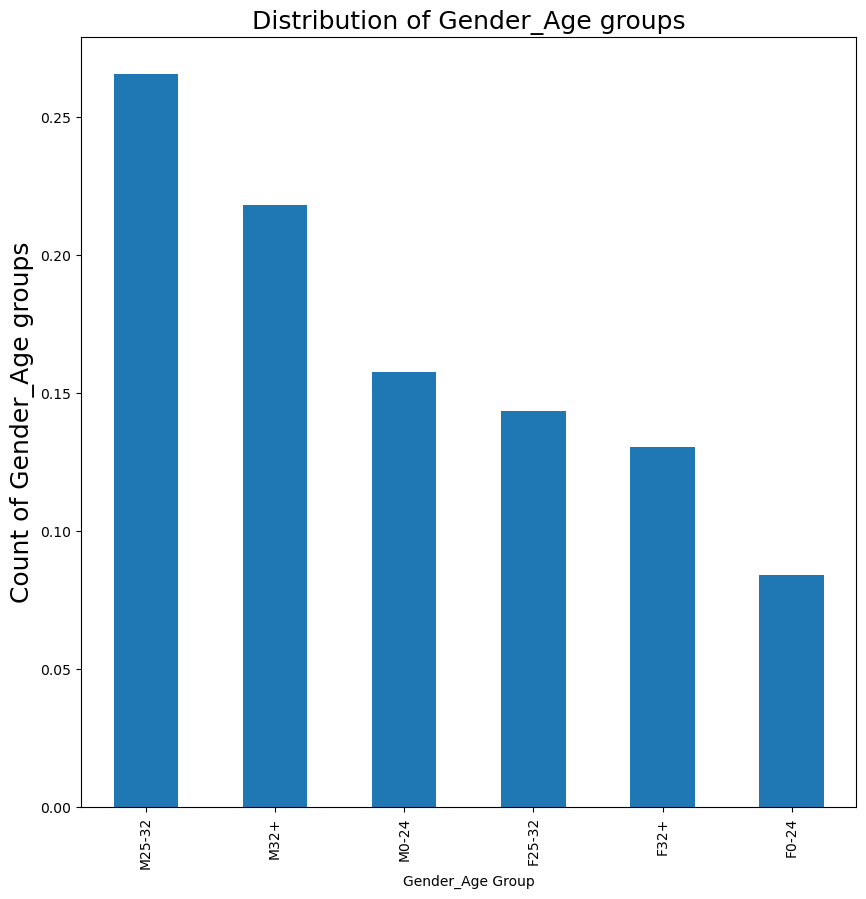

In [44]:

df_train_mobile['group_train'].value_counts(normalize=True).plot(kind='bar',figsize=(10,10))
plt.xlabel('Gender_Age Group',fontsize=10)
plt.ylabel('Count of Gender_Age groups',fontsize=18)
plt.title('Distribution of Gender_Age groups',fontsize =18)
plt.show()

- For `male` population most of the data lies in  M(25-32 yrs age) category which might be related to fact that the youth population tend to use mobile phone more as compared to older age group.
- For `female` population as well the same pattern as in males is observed with 25-32 yrs age category is the dominant category among all the others.


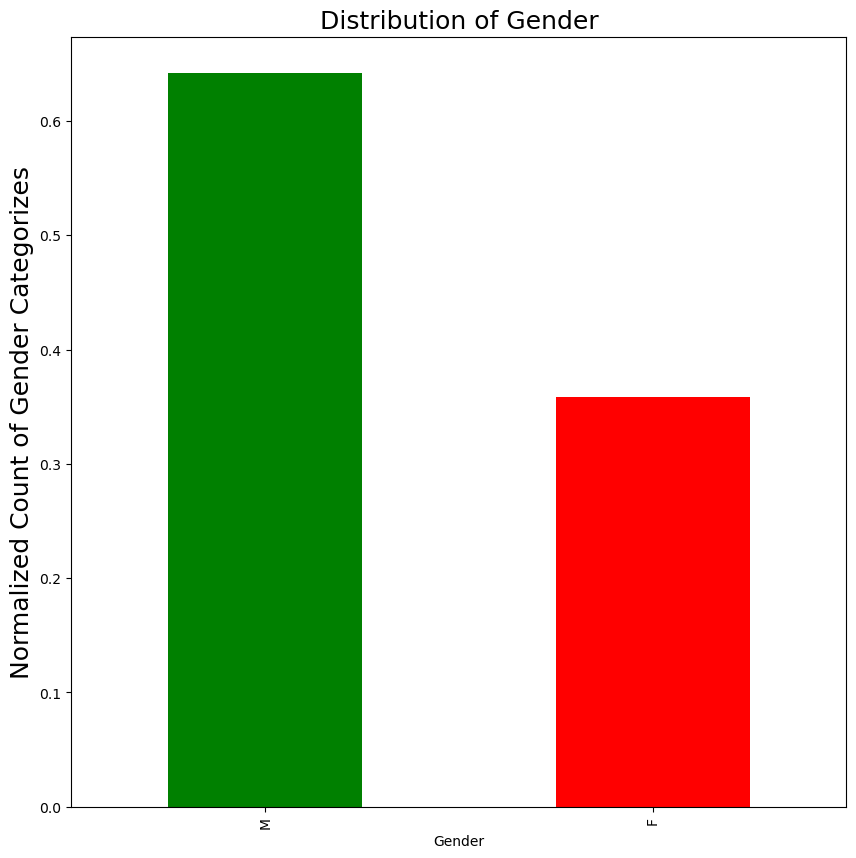

In [45]:
c = ['green', 'red']
df_train_mobile['gender'].value_counts(normalize=True).plot(kind='bar',figsize=(10,10), color = c)
plt.xlabel('Gender',fontsize=10)
plt.ylabel('Normalized Count of Gender Categorizes',fontsize=18)
plt.title('Distribution of Gender',fontsize =18)
plt.show()

- In train_mobile_brand around 60% of data belongs to male category and 40% belong to female category.
- As gender is target variable and it is not balanced, the prediciton model that would be built has to incorporate the fact that dataset is imbalanced.

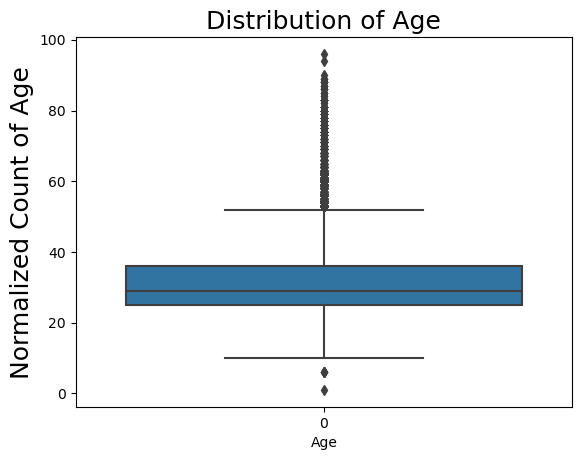

In [46]:
sns.boxplot(data  = df_train_mobile['age'])
plt.xlabel('Age',fontsize=10)
plt.ylabel('Normalized Count of Age',fontsize=18)
plt.title('Distribution of Age',fontsize =18)
plt.show()

- On analyzing the `age` variable it seems it has some outliers as there are some present on the upper and lower half of the box plot.
- Will also plot distplot to see where are the gaps in data.

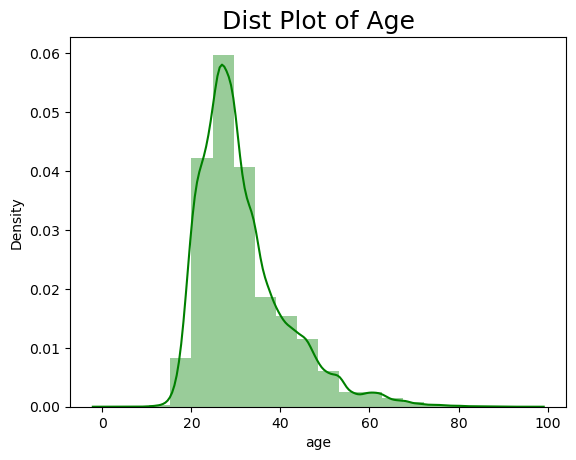

In [47]:
sns.distplot(df_train_mobile['age'], bins=20,color='g') #Seaborn
plt.title('Dist Plot of Age',fontsize =18)
plt.show()

- It is very less likely that people above age of 80 use mobile phone apps, keeping them would led to some noise in the data.
- So, it would be fine to remove the rows where age of person is greater than 80.
- On the other hand children do not have phones below age of 15 or if they have are not aware of how to use apps.In such cases we can also remove them as indicated as outliers in the box plot.

In [48]:
df_train_mobile.shape

(74646, 6)

In [49]:
#Removing rows where age > 80
df_train_mobile = df_train_mobile[~(df_train_mobile['age'] > 80)]
df_train_mobile.shape

(74600, 6)

In [50]:
#Removing rows where age < 15
df_train_mobile = df_train_mobile[~(df_train_mobile['age'] < 15 )]
df_train_mobile.shape

(74522, 6)

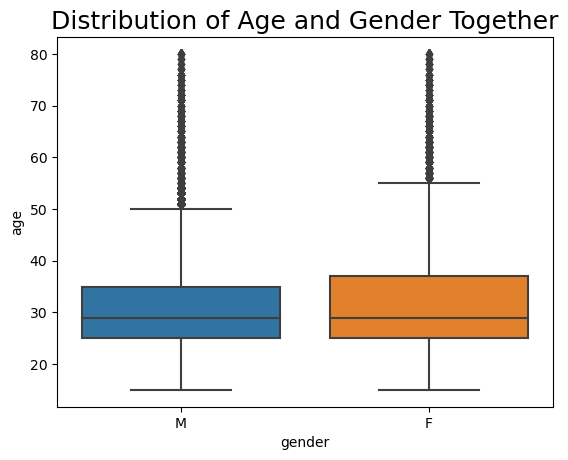

In [51]:
sns.boxplot(data  = df_train_mobile, x='gender',y='age')
plt.title('Distribution of Age and Gender Together',fontsize =18)
plt.show()

- For both male and female the median age is 30 yrs of age.
- In case of females there is more spread in age as the 75% of age for females is more than that of males.

In [52]:
def assign_age_group(age):
    '''
    param age(int):Age of the person
    returns age_group(str):As per the different groups which age group the person's age belong to
    '''
    if 0<= age <=24:
        return '0-24'
    elif 25<= age <=32:
        return '25-32'
    elif 33<= age <=45:
        return '33-45'
    else:
        return '46+'

In [53]:
#Creating age groups for EDA
df_train_mobile['age_group'] = df_train_mobile['age'].apply(lambda x:assign_age_group(x))

In [54]:
df_train_mobile['age_group'].value_counts()

25-32    30553
33-45    18911
0-24     17976
46+       7082
Name: age_group, dtype: int64

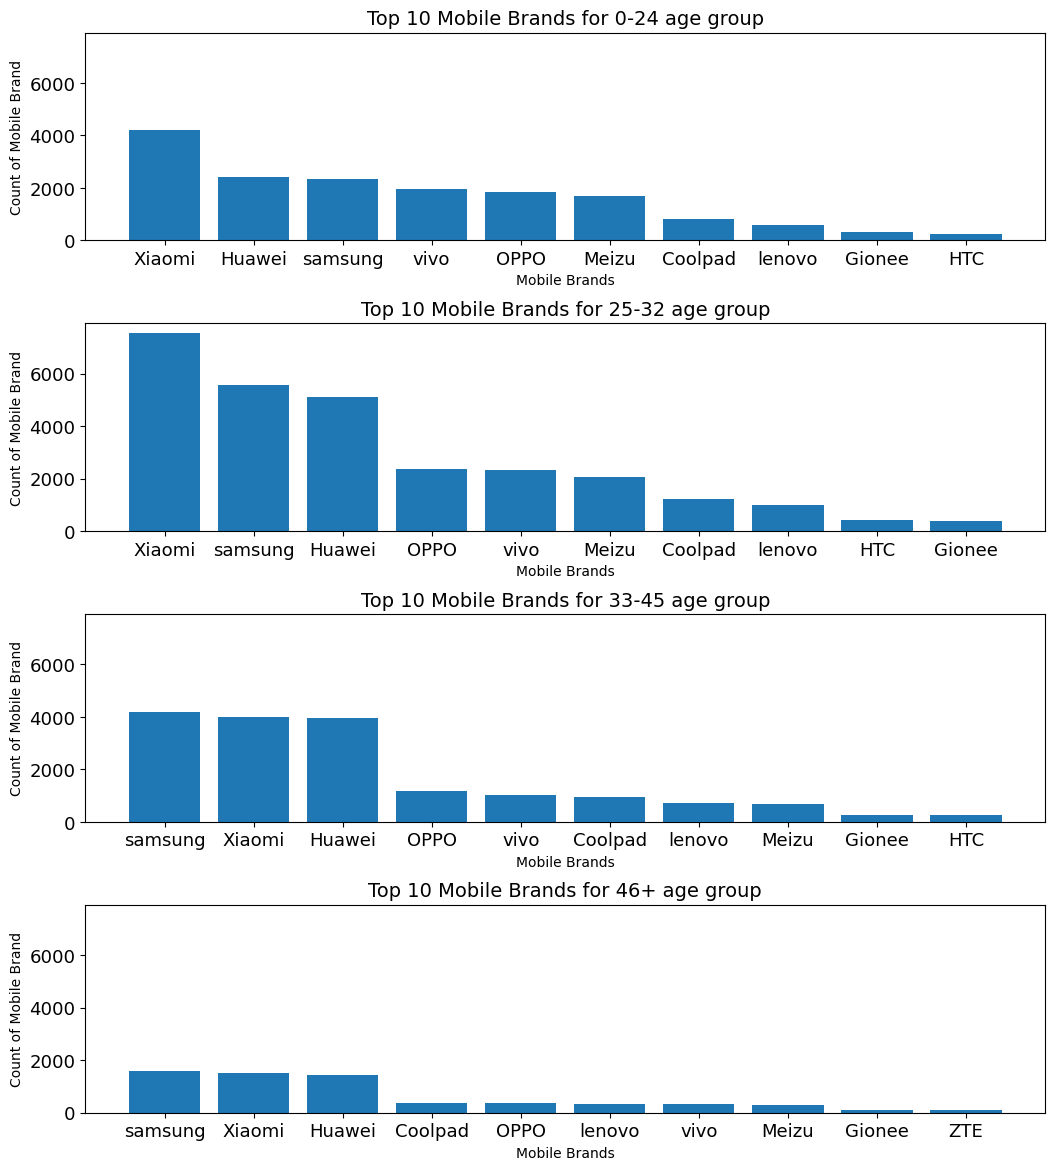

In [55]:
#Top 10 mobile phone brands by age groups 
df_grouped = df_train_mobile.groupby(['age_group','phone_brand']).size().sort_values(ascending=False)
fig, ax = plt.subplots(4,1, sharey=True)

#For age group 0-24
top10 = df_grouped.get('0-24')[:10]
x = []
y = []
for counter in range(10):
    x.append(top10.index[counter])
    y.append(top10[counter])
ax[0].bar(x,y)
ax[0].set_xlabel('Mobile Brands', fontsize=10)
ax[0].set_ylabel('Count of Mobile Brand',fontsize=10)
ax[0].tick_params(labelsize=13)
ax[0].set_title('Top 10 Mobile Brands for 0-24 age group',fontsize =14)


#For age group 25-32
top10 = df_grouped.get('25-32')[:10]
x = []
y = []
for counter in range(10):
    x.append(top10.index[counter])
    y.append(top10[counter])
ax[1].bar(x,y)
ax[1].set_xlabel('Mobile Brands', fontsize=10)
ax[1].set_ylabel('Count of Mobile Brand',fontsize=10)
ax[1].tick_params(labelsize=13)
ax[1].set_title('Top 10 Mobile Brands for 25-32 age group',fontsize =14)


#For age group 33-45
top10 = df_grouped.get('33-45')[:10]
x = []
y = []
for counter in range(10):
    x.append(top10.index[counter])
    y.append(top10[counter])
ax[2].bar(x,y)
ax[2].set_xlabel('Mobile Brands', fontsize=10)
ax[2].set_ylabel('Count of Mobile Brand',fontsize=10)
ax[2].tick_params(labelsize=13)
ax[2].set_title('Top 10 Mobile Brands for 33-45 age group',fontsize =14)

#For age group 46+
top10 = df_grouped.get('46+')[:10]
x = []
y = []
for counter in range(10):
    x.append(top10.index[counter])
    y.append(top10[counter])
ax[3].bar(x,y)
ax[3].set_xlabel('Mobile Brands', fontsize=10)
ax[3].set_ylabel('Count of Mobile Brand',fontsize=10)
ax[3].tick_params(labelsize=13)
ax[3].set_title('Top 10 Mobile Brands for 46+ age group',fontsize =14)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.7, 
                    wspace=0.4, 
                    hspace=0.4)

fig.set_size_inches(12, 18, forward=True)

- `Xiaomi` and `Samsung` seem to be the popular mobile brands preferred by customers across different age groups.
- `Gionee` and `HTC` are the least preferred mobile brands by customers across different age groups.
- As the age group increases usage of mobile phone is decreased as observed from above bar plots.

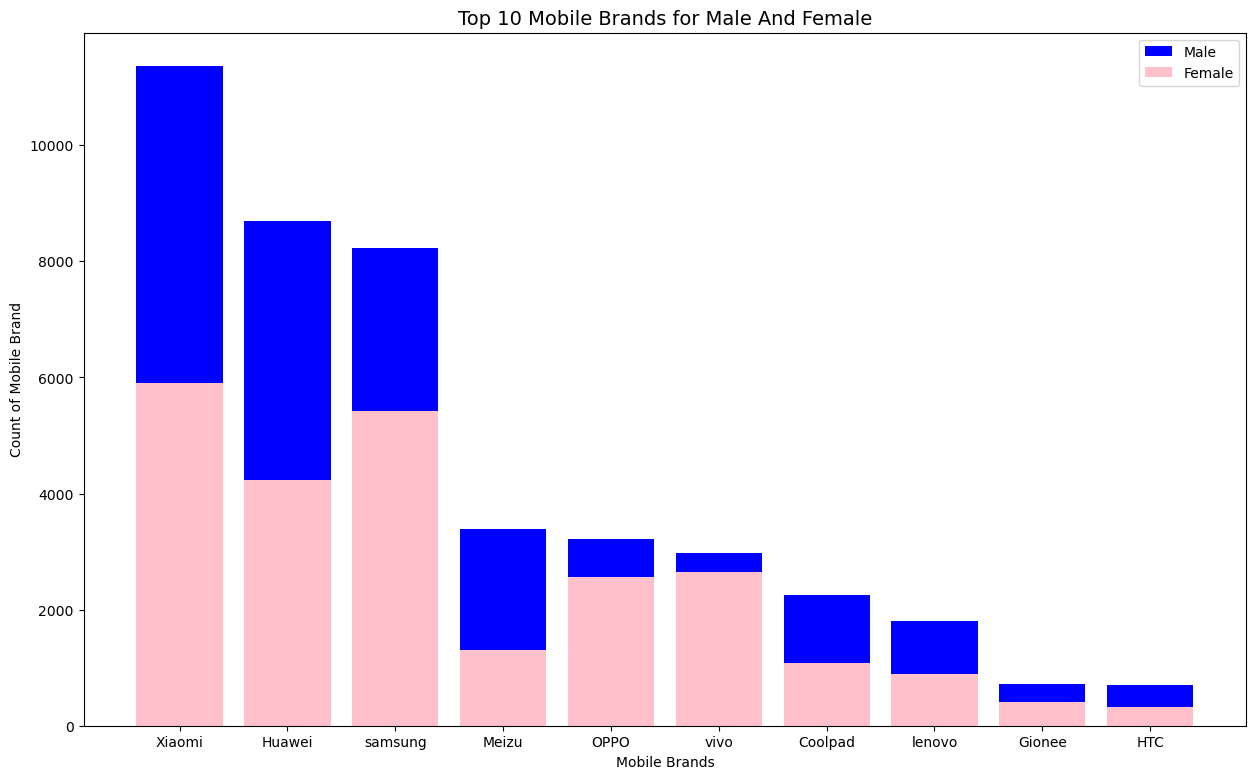

In [56]:
#Top 10 mobile phone brands by gender
plt.figure(figsize=(15,9))
df_grouped = df_train_mobile.groupby(['gender','phone_brand']).size().sort_values(ascending=False)

top10_m = df_grouped.get('M')[:10]
x = []
y = []
for counter in range(10):
    x.append(top10_m.index[counter])
    y.append(top10_m[counter])
plt.bar(x,y,color='b')

top10_f = df_grouped.get('F')[:10]
x = []
y = []
for counter in range(10):
    x.append(top10_f.index[counter])
    y.append(top10_f[counter])

plt.bar(x,y,color='pink')

plt.xlabel('Mobile Brands', fontsize=10)
plt.ylabel('Count of Mobile Brand',fontsize=10)
plt.title('Top 10 Mobile Brands for Male And Female',fontsize =14)
plt.legend(['Male','Female'])
plt.show()

- In case where mobile brand is <i>Xiamoi,Huawei,Samsung,Meizu,Coolpad and Lenevo</i> male population tend to prefer it more as compared to the female population.
- Mobile brands like <i>Oppo , vivo, gionee and htc</i> are equally common among male and female population.


#### Analyzing train_event data

In [57]:
df_train_event.head()

device_id gender  age group_train  event_id       datetimestamp  \
0 -7548291590301750000      M   33        M32+   2369465 2016-05-03 15:55:35   
1 -7548291590301750000      M   33        M32+   1080869 2016-05-03 06:07:16   
2 -7548291590301750000      M   33        M32+   1079338 2016-05-04 03:28:02   
3 -7548291590301750000      M   33        M32+   1078881 2016-05-04 02:53:08   
4 -7548291590301750000      M   33        M32+   1068711 2016-05-03 15:59:35   

   latitude  longitude  
0     33.98     116.79  
1     33.98     116.79  
2     33.98     116.79  
3     33.98     116.79  
4     33.98     116.79

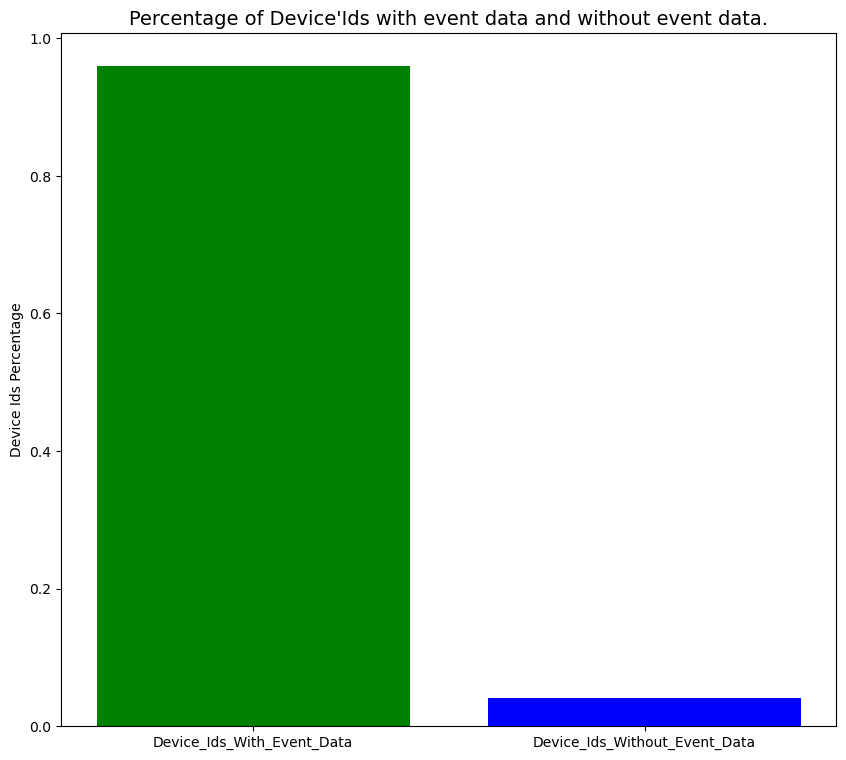

In [58]:
#Percentage of Device'Ids with event data and without event data.
#During Data cleaning process where the event_id was missing it was assigned with a value of 0.
plt.figure(figsize=(10,9))

device_ids_without_event = df_train_event[df_train_event['event_id'] == 0]
device_ids_with_event = df_train_event[~(df_train_event['event_id'] == 0)]

x = ['Device_Ids_With_Event_Data','Device_Ids_Without_Event_Data']
y = [len(device_ids_with_event)/len(df_train_event),len(device_ids_without_event)/len(df_train_event)]


plt.bar(x,y,color=['g','b'])
plt.ylabel('Device Ids Percentage',fontsize=10)
plt.title("Percentage of Device'Ids with event data and without event data.",fontsize =14)
plt.show()

- Around `4%` of data is present where there is no event data for device_ids which represents the consumer either switched off the location or did not provide consent for sharing location data.
- `96%` of data has event_data associated with the device id which would help in recommendation tasks.

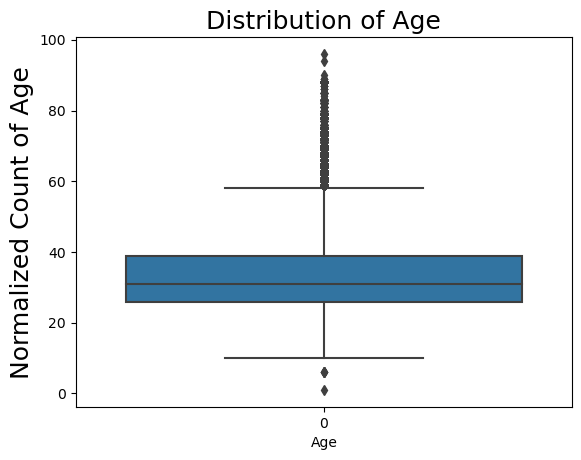

In [59]:
sns.boxplot(data  = df_train_event['age'])
plt.xlabel('Age',fontsize=10)
plt.ylabel('Normalized Count of Age',fontsize=18)
plt.title('Distribution of Age',fontsize =18)
plt.show()

- As we had observed earlier in train_mobile_brand data age has certain outliers which needs to be removed.

In [60]:
#Removing rows where age > 80
df_train_event = df_train_event[~(df_train_event['age'] > 80)]
df_train_event.shape

(1265979, 8)

In [61]:
#Removing rows where age < 15
df_train_event = df_train_event[~(df_train_event['age'] < 15 )]
df_train_event.shape

(1265823, 8)

In [62]:
#Creating age groups for EDA
df_train_mobile['age_group'] = df_train_mobile['age'].apply(lambda x:assign_age_group(x))

In [63]:
#Check if any spike on number of events on different days.

In [64]:
#Monday is 0 and Sunday is 6
DAY_MAPPING = {
    0 : 'Monday',
    1: 'Tuesday',
    2 : 'Wednesday',
    3 : 'Thursday',
    4 : 'Friday',
    5 : 'Saturday',
    6 : 'Sunday'
}

In [65]:
def get_day_from_date(date_obj):
    '''
    :param date_obj(timestamp object):Datetime object
    :returns (str):Day name on the given date.In some cases the date_obj was Nan so it was assigned default 0 which takes
                   1970 as default year.So in this case it would be assigned as 'Data Not Available'
    '''
    if date_obj.year == 1970:
        return 'Data Not Available'
    return DAY_MAPPING.get(date_obj.weekday(),'')

In [66]:
#Getting day of the week from the datetimestamp column
df_train_event['Day'] = df_train_event['datetimestamp'].apply(lambda x: get_day_from_date(x))
df_train_event['Day'].value_counts()

Tuesday               180184
Thursday              179914
Wednesday             178279
Friday                176539
Monday                169252
Saturday              166525
Sunday                163891
Data Not Available     51239
Name: Day, dtype: int64

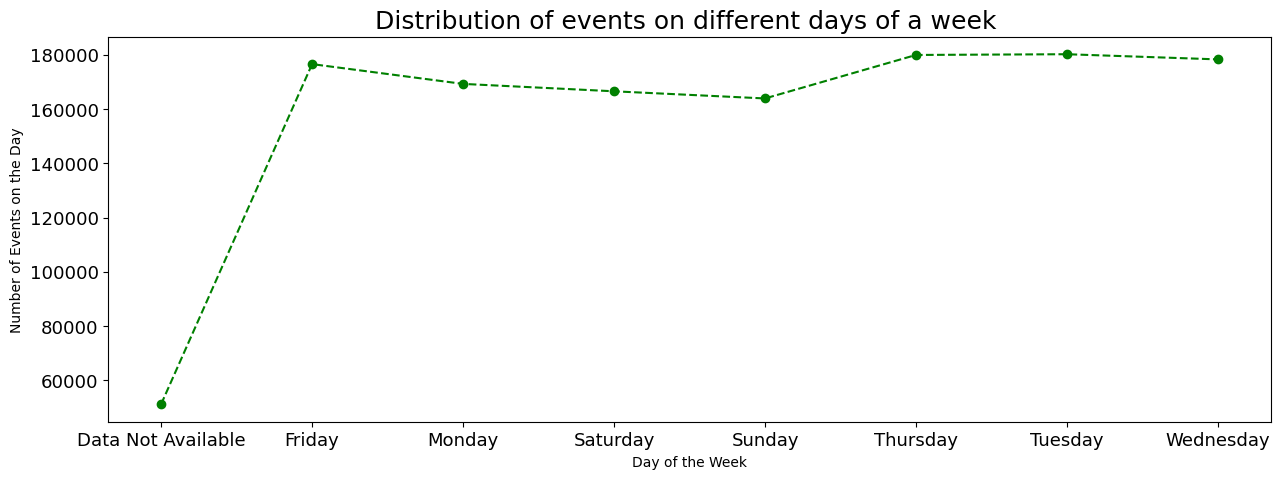

In [67]:
plt.figure(figsize=(15,5))
plt.plot(df_train_event.groupby('Day').size(),color='green', linestyle='dashed', marker='o')
plt.xlabel('Day of the Week',fontsize=10)
plt.ylabel('Number of Events on the Day',fontsize=10)
plt.title('Distribution of events on different days of a week ',fontsize =18)
plt.tick_params(labelsize=13)


- `Friday` has higher number of events as compared to Saturday and Sunday which might suggests that consumers tend to not use mobile phones much on weekend as they want some break.
- `Thursday`,`Tuesday` and `Wednesday` have roughly the same values and is higher than other days since these are working days consumers might be using their mobile phones more

In [68]:
#Getting hour from the datetimestamp column
df_train_event['Hour'] = df_train_event['datetimestamp'].apply(lambda x: x.hour if x.year != 1970 else 'Data Not Available' )

In [69]:
df_train_event['Hour'].value_counts()

10                    68464
21                    67469
20                    65019
11                    62868
12                    62469
9                     62117
22                    61966
19                    61908
8                     59009
13                    58263
17                    58179
18                    57581
16                    56987
14                    56262
7                     55487
15                    55189
23                    51497
Data Not Available    51239
0                     44840
6                     43950
1                     27065
5                     24503
2                     20236
3                     16984
4                     16272
Name: Hour, dtype: int64

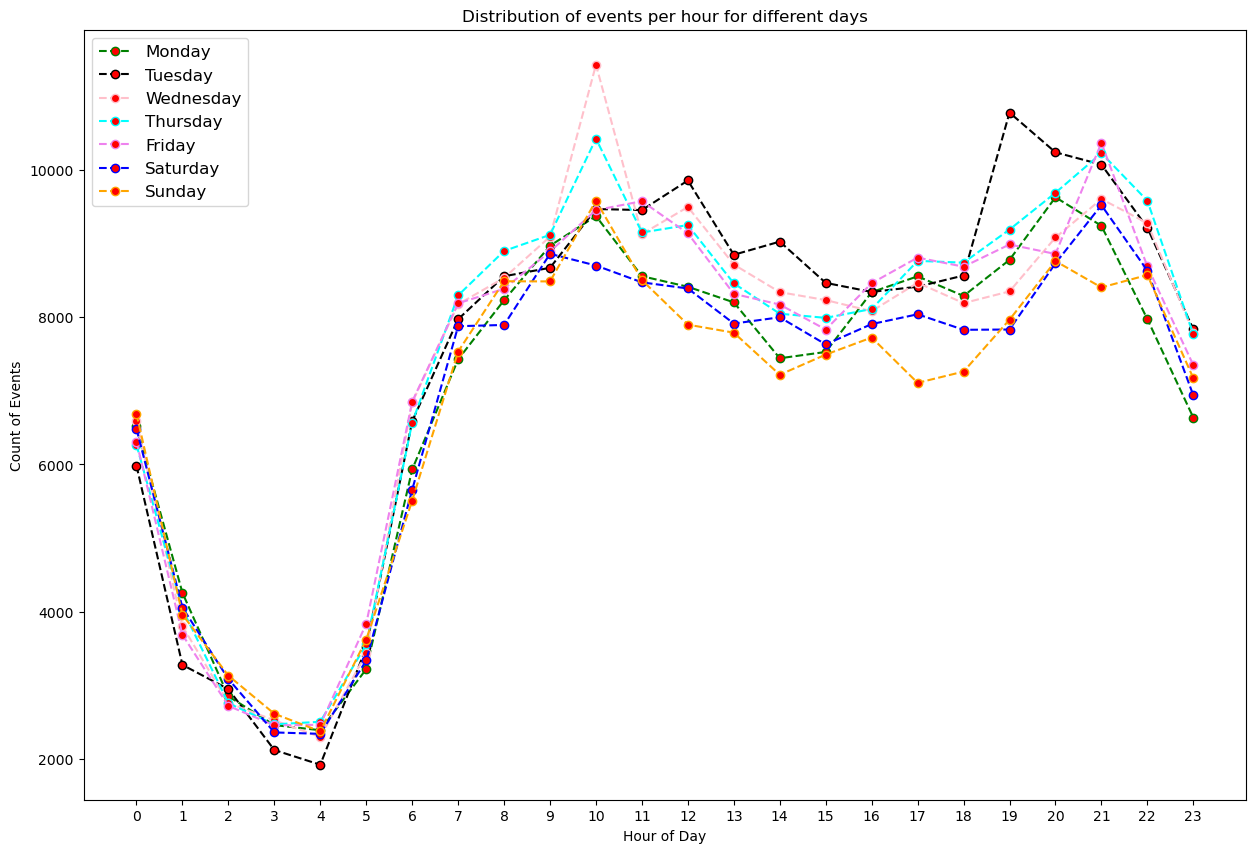

In [70]:
# Plotting Distribution of events per hour for different days
# fig, ax = plt.subplots(7,1, sharey=True)
plt.figure(figsize=(15,10))
days =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
colors = ['green','black','pink','cyan','violet','blue','orange']
x = list(range(0,24))
for index in range(len(days)):
    y = df_train_event.groupby(['Day','Hour']).size().get(days[index])
    plt.plot(x,y, marker='o',mfc='red',color=colors[index], linestyle='dashed')
plt.xticks(x)
plt.legend(labels=days,fontsize = 12,loc='best')
plt.title('Distribution of events per hour for different days',fontsize = 12)
plt.xlabel('Hour of Day',fontsize = 10)
plt.ylabel('Count of Events',fontsize = 10)
plt.show()

- There is sort of pattern on apps consumed by the consumer as during late night i.e from 12 am to 5 am(0-4) on bottom left of the above graph we can see the usage of apps is very less.This can be due to the fact that it is sleep time for most of the people residing in India so usage of phone is less.
- Usage of apps increases from 6 am and goes on increasing till 11 am(6-11) for all the days as indicated by middle portion of the graph.
- During office hours from 12pm to 5pm(12-17) the count of events is less which is expected behaviour.
- From 6pm to 8pm(18-20) there is a spike in number of events which might be due to the fact that most of the offices end by 6pm.
- App consumption goes down after 8pm till 11 pm.
- During 9-10 am on Thursday we observe highest number of events which also coincides with our previous conclusion that there is peak of events on Thursday.
- On Tuesday there is a peak between 6-7 pm which is different from other days.

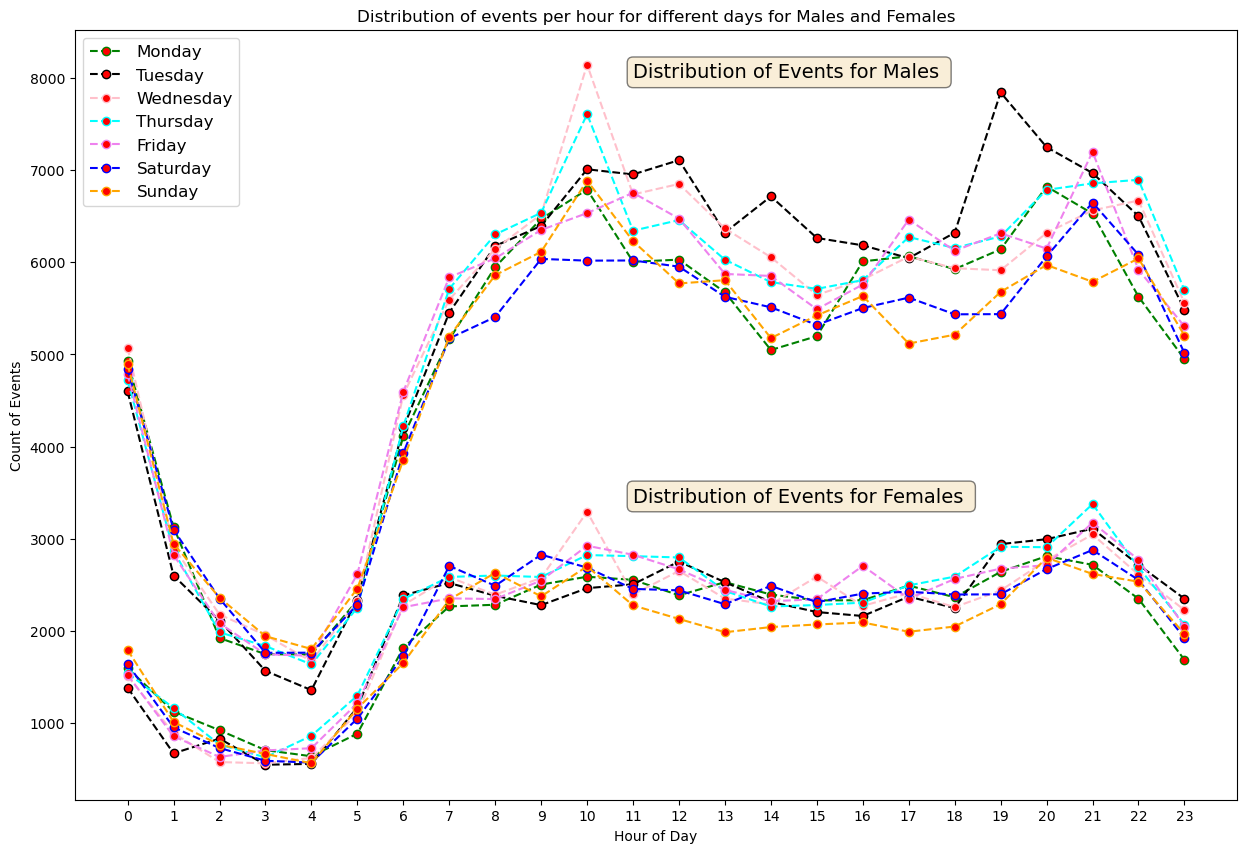

In [71]:
# Plotting Distribution of events per hour for different days for Males and Females
# fig, ax = plt.subplots(2,1, sharey=True)
plt.figure(figsize=(15,10))
days =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
colors = ['green','black','pink','cyan','violet','blue','orange']
x = list(range(0,24))
data = df_train_event.groupby(['Day','Hour','gender']).size()

def plot_events_data(male_female_flag = 'F'):
    gender = 'Females' if male_female_flag == 'F' else 'Males'
    for index in range(len(days)):
        y = data.get(days[index])[:,male_female_flag]
        plt.plot(x,y, marker='o',mfc='red',color=colors[index], linestyle='dashed')

#For Females
plot_events_data()

#For males
plot_events_data('M')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(11,8000, 'Distribution of Events for Males ', fontsize=14, bbox=props)
plt.text(11,3400, 'Distribution of Events for Females ', fontsize=14, bbox=props)



plt.xticks(x)
plt.legend(labels=days,fontsize = 12,loc='best')
plt.title('Distribution of events per hour for different days for Males and Females',fontsize = 12)
plt.xlabel('Hour of Day',fontsize = 10)
plt.ylabel('Count of Events',fontsize = 10)
plt.show()

- In the above graph the top half is of `Males` and bottom half is of `Females`.
- In general more events are there for males as compared to males for all hours of day and all days of the week.
- The peaks that were observed earlier on Friday, Thursday and Tuesday between 9-10 am is common for both males and females.
- Events usage data tends to fluctuate more in case of males whereas in Females after 8 am there is not much difference in number of events.

In [72]:
#Creating age groups for EDA
df_train_event['age_group'] = df_train_event['age'].apply(lambda x:assign_age_group(x))

In [73]:
df_train_event['age_group'].value_counts()

25-32    500572
33-45    410247
0-24     198215
46+      156789
Name: age_group, dtype: int64

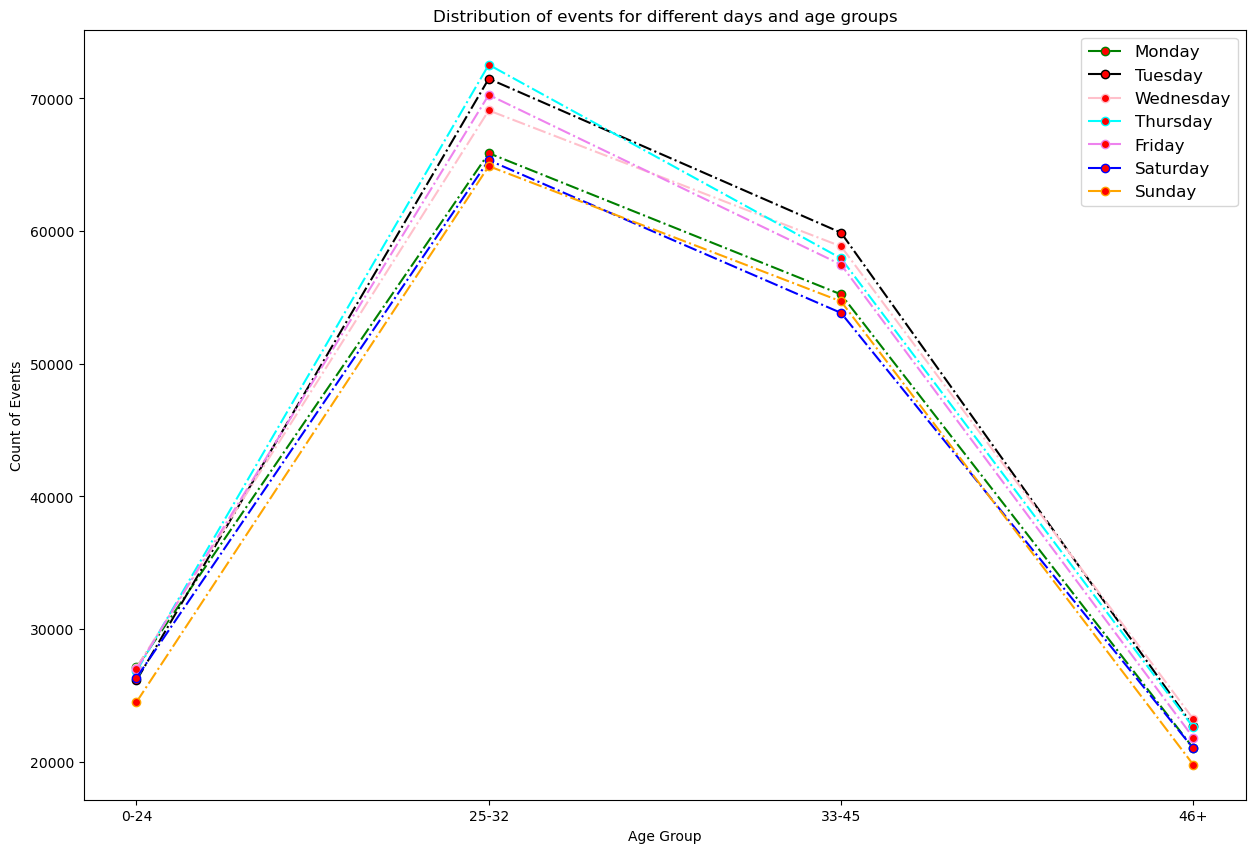

In [74]:
# Plotting Distribution of events for different days and age groups
# fig, ax = plt.subplots(7,1, sharey=True)
plt.figure(figsize=(15,10))
days =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
colors = ['green','black','pink','cyan','violet','blue','orange']
x = ['0-24','25-32','33-45','46+']
data = df_train_event.groupby(['Day','age_group']).size()
for index in range(len(days)):
    y = data.get(days[index])
    plt.plot(x,y, marker='o',mfc='red',color=colors[index], linestyle='dashdot')
plt.xticks(x)
plt.legend(labels=days,fontsize = 12,loc='best')
plt.title('Distribution of events for different days and age groups',fontsize = 12)
plt.xlabel('Age Group',fontsize = 10)
plt.ylabel('Count of Events',fontsize = 10)
plt.show()

- Age group from 25-32 have the highest number of events on all days when compared with other age groups.This can be due to the fact that in this age group people are more active on their phone hence more event data.
- 46+ and 0-24 age group  people tend to use phone less as compared to other age groups which is also depicted in the plot above.
- As we had observed earlier Tuesday,Wednesday,Thursday and Friday seems to be most active in number of events generated for all age groups.

#### Analyzing app_events data

In [75]:
#Merging the app_events and train_event data
df_app = df_train_event.merge(df_app_events,on = 'event_id',how = 'inner')
df_app.shape

(12230622, 14)

In [76]:
df_app.head()

device_id gender  age group_train  event_id       datetimestamp  \
0 -7548291590301750000      M   33        M32+   1141870 2016-05-01 10:08:16   
1 -7548291590301750000      M   33        M32+   1141870 2016-05-01 10:08:16   
2 -7548291590301750000      M   33        M32+   1141870 2016-05-01 10:08:16   
3 -7548291590301750000      M   33        M32+   1141870 2016-05-01 10:08:16   
4 -7548291590301750000      M   33        M32+   1141870 2016-05-01 10:08:16   

   latitude  longitude     Day Hour age_group        app_id  is_installed  \
0     33.98     116.79  Sunday   10     33-45  3.433290e+18             1   
1     33.98     116.79  Sunday   10     33-45 -5.472633e+18             1   
2     33.98     116.79  Sunday   10     33-45  9.112463e+18             1   
3     33.98     116.79  Sunday   10     33-45  8.693964e+18             1   
4     33.98     116.79  Sunday   10     33-45  5.099454e+18             1   

   is_active  
0          1  
1          1  
2          0  
3          1  
4          1

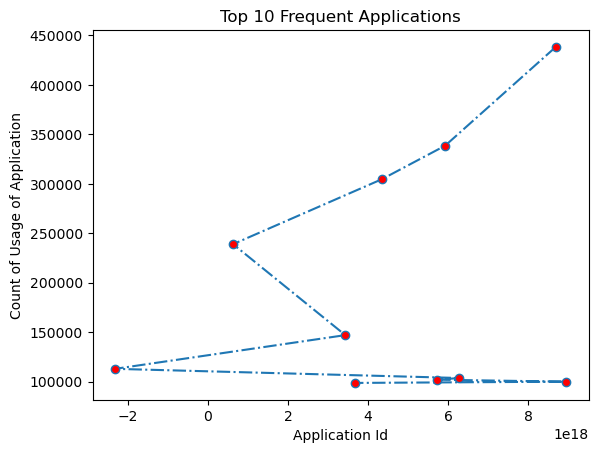

[8693964245073640448, 5927333115845830656, 4348659952760821248, 628020936226491264, 3433289601737013248, -2320783822570583040, 6284164581582111744, 5729517255058371584, 8948670408023620608, 3683147815759994368]
[438444, 338510, 304652, 238921, 146930, 112828, 103553, 101850, 99843, 98581]


In [77]:
#10 frequent applications
data = df_app.groupby('app_id').size().sort_values(ascending=False)
top10apps = list(df_app.groupby('app_id').size().sort_values(ascending=False).index[:10])
X = [int(val) for val in df_app.groupby('app_id').size().sort_values(ascending=False).index[:10]]
Y = [int(val) for val in df_app.groupby('app_id').size().sort_values(ascending=False).values[:10]]

plt.plot(X,Y, marker='o',mfc='red', linestyle='dashdot')
plt.title('Top 10 Frequent Applications',fontsize = 12)
plt.xlabel('Application Id',fontsize = 10)
plt.ylabel('Count of Usage of Application',fontsize = 10)
plt.show()
print(X)#Top 10 app_ids
print(Y)

- App Id `8693964245073640448` has the highest usage in comparison to other apps.
- App Id `3683147815759994368` has the lowest usage in comparison to other apps.

Top 10 App Ids Mapping
App Id:8693964245073640448 has Rank1
App Id:5927333115845830656 has Rank2
App Id:4348659952760821248 has Rank3
App Id:628020936226491264 has Rank4
App Id:3433289601737013248 has Rank5
App Id:-2320783822570583040 has Rank6
App Id:6284164581582111744 has Rank7
App Id:5729517255058371584 has Rank8
App Id:8948670408023620608 has Rank9
App Id:3683147815759994368 has Rank10


<Figure size 1500x1000 with 0 Axes>

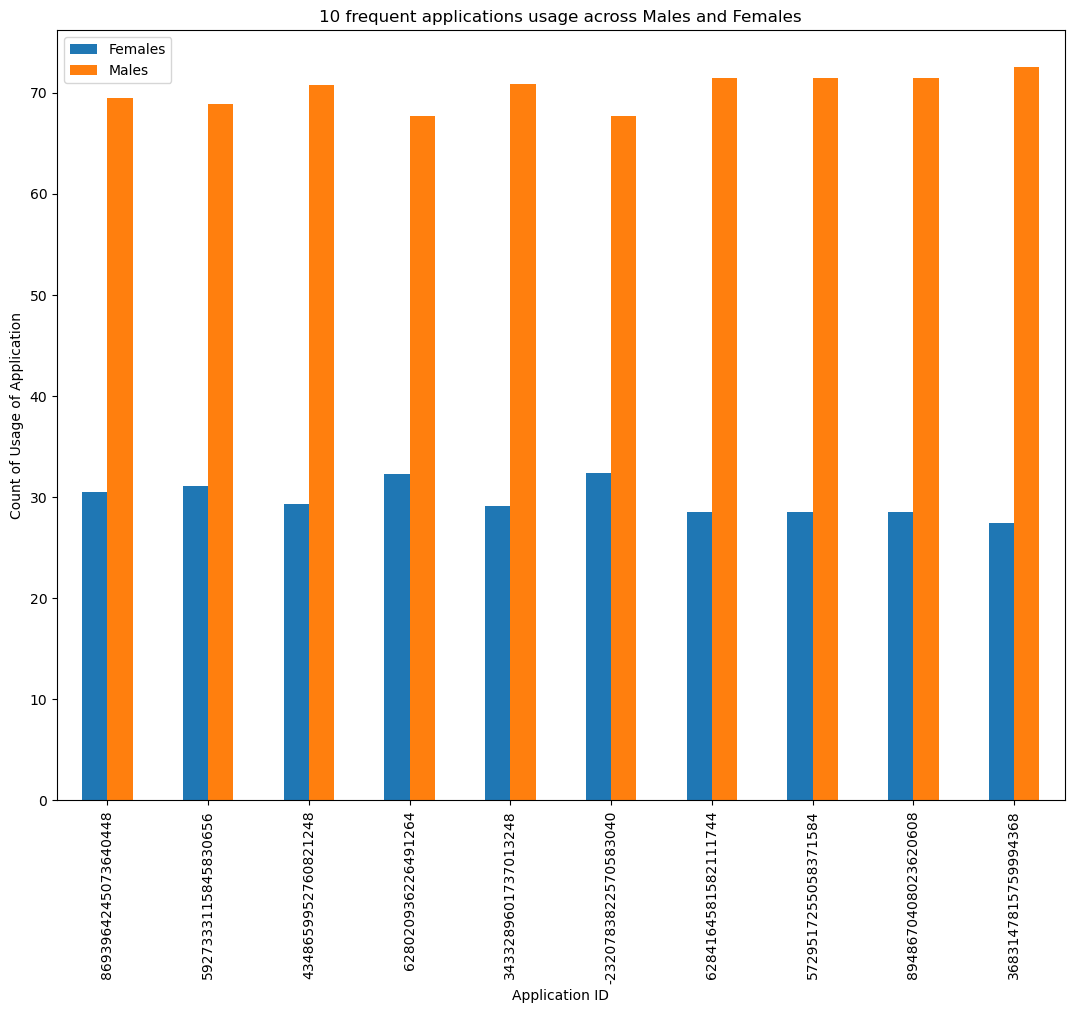

In [78]:
#10 frequent applications usage across Males and Females
plt.figure(figsize=(15,10))
x = list(range(0,24))
#Segregating the data as per the top 10 application ids and then segregating as per gender.
data = df_app[df_app['app_id'].isin(top10apps)].groupby(['gender','app_id']).size().sort_values(ascending=False)
top10apps_dict = {top10apps[index]:f'Rank{index + 1}' for index in range(len(top10apps))}

print('Top 10 App Ids Mapping')
for k,v in top10apps_dict.items():
    print(f'App Id:{int(k)} has {v}')

    
#For Females
female_values = data.get('F').values
#For males
male_values = data.get('M').values

female_percentage = [female_values[index]/(female_values[index] + male_values[index])*100 for index in range(10)]
male_percentage = [male_values[index]/(female_values[index] + male_values[index])*100 for index in range(10)]
data_dict = {'FemalePercentageAppUsage':female_percentage,'MalePercentageAppUsage':male_percentage}
df_top_10_gender = pd.DataFrame(data = data_dict)
df_top_10_gender.index = [int(val) for val in top10apps]
df_top_10_gender.plot(kind = 'bar',figsize=(13,10))

plt.legend(labels=['Females','Males'],fontsize = 10,loc='best')
plt.title('10 frequent applications usage across Males and Females',fontsize = 12)
plt.xlabel('Application ID',fontsize = 10)
plt.ylabel('Count of Usage of Application',fontsize = 10)
plt.show()

- For most used app_id `8693964245073640448` males tend to have a higher usage as compared to females.
- In general for all the top 10 applications males tend to have a higher usage when compared with females.There is a significant difference in usage of top 10 apps when compared.
- In case of females app Ids `-2320783822570583040` and `628020936226491264` tend to have higher usage when compared with other apps.
- In case of males app Id `3683147815759994368` has the highest usage.


### Visualzing Geospatial Data

In [79]:
df_events = df_train_event[df_train_event['event_id'] != 0]
df_events.shape

(1214584, 11)

In [80]:
#Taking out 100000 samples
df_events_sample = df_events.sample(n=100000)
df_events_sample.shape

(100000, 11)

In [81]:
def plot_geo_data(df_data, lon_min = None, lon_max = None, lat_min = None, lat_max = None,isSpecific = False,filterBy = None,filterByColumn = ''):
    if filterBy:
        df_data = df_data[df_data[filterByColumn]==filterBy]
    if isSpecific:
        idx = (df_data["longitude"] > lon_min) &\
              (df_data["longitude"] < lon_max) &\
              (df_data["latitude"] > lat_min) &\
              (df_data["latitude"] < lat_max)
        df_data = df_data[idx]    
    df_events_sample = df_data
    if len(df_data) > 100000:
        df_events_sample = df_data.sample(n=100000)
    
    #Meractor of World
    m1 = Basemap(projection='merc',
                 llcrnrlat =  lat_min if isSpecific else -60  , #lower left corner latitude value
                 urcrnrlat=lat_max if isSpecific else 65, #upper right corner latitude value
                 llcrnrlon=lon_min if isSpecific else -180, #lower left corner longitude value
                 urcrnrlon=lon_max if isSpecific else 180, #upper right corner longitude value
                 lat_ts=0,
                 resolution='c')
    
    m1.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
    m1.drawmapboundary(fill_color='#000000') # balck background
    m1.drawcountries(linewidth=0.1, color='w') #thin white line for country borders
    mxy = m1(df_events_sample["longitude"].tolist(), df_events_sample["latitude"].tolist())
    m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

    

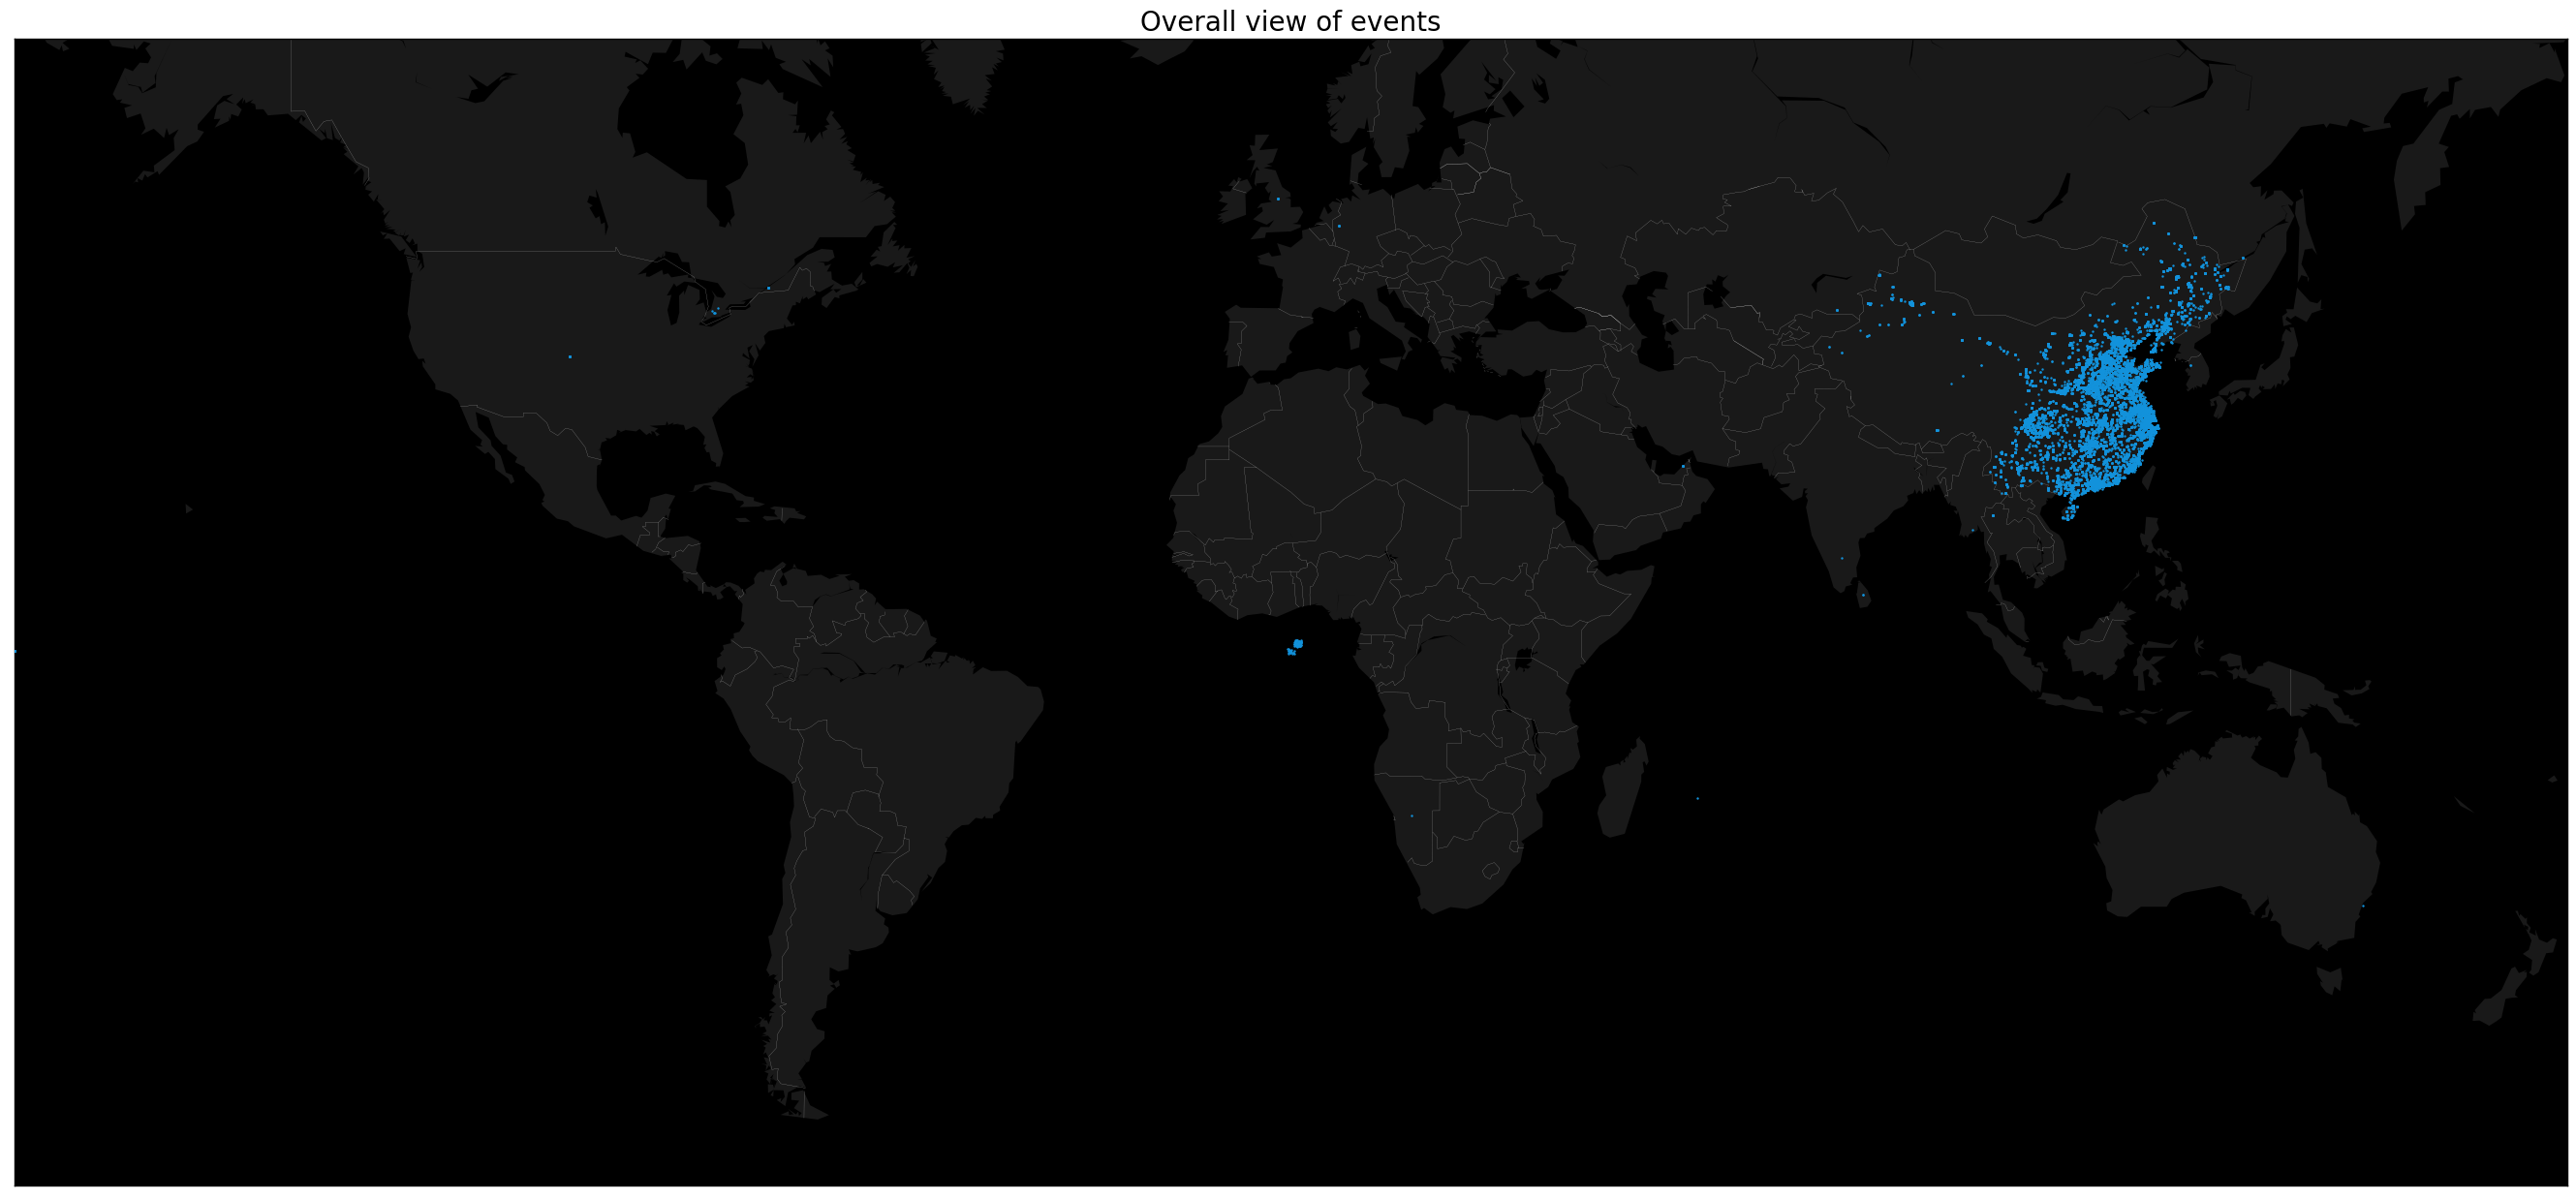

In [82]:
# Overall view of events(geo plot)
plt.figure(1, figsize=(34,20))
plot_geo_data(df_events_sample)
plt.title("Overall view of events",fontsize=20)
plt.show()

- It looks like most of the data is coming from APAC side from China.

In [83]:
df_0 = df_events[(df_events["longitude"] ==0) & (df_events["latitude"] ==0)]
df_0_around = df_events[(df_events["longitude"] > -1) & \
                   (df_events["longitude"] < 1) &\
                   (df_events["latitude"] >-1) &\
                   (df_events["latitude"] <1)]

print(len(df_events))
print(len(df_0))
print(len(df_0_around))

1214584
355964
356377


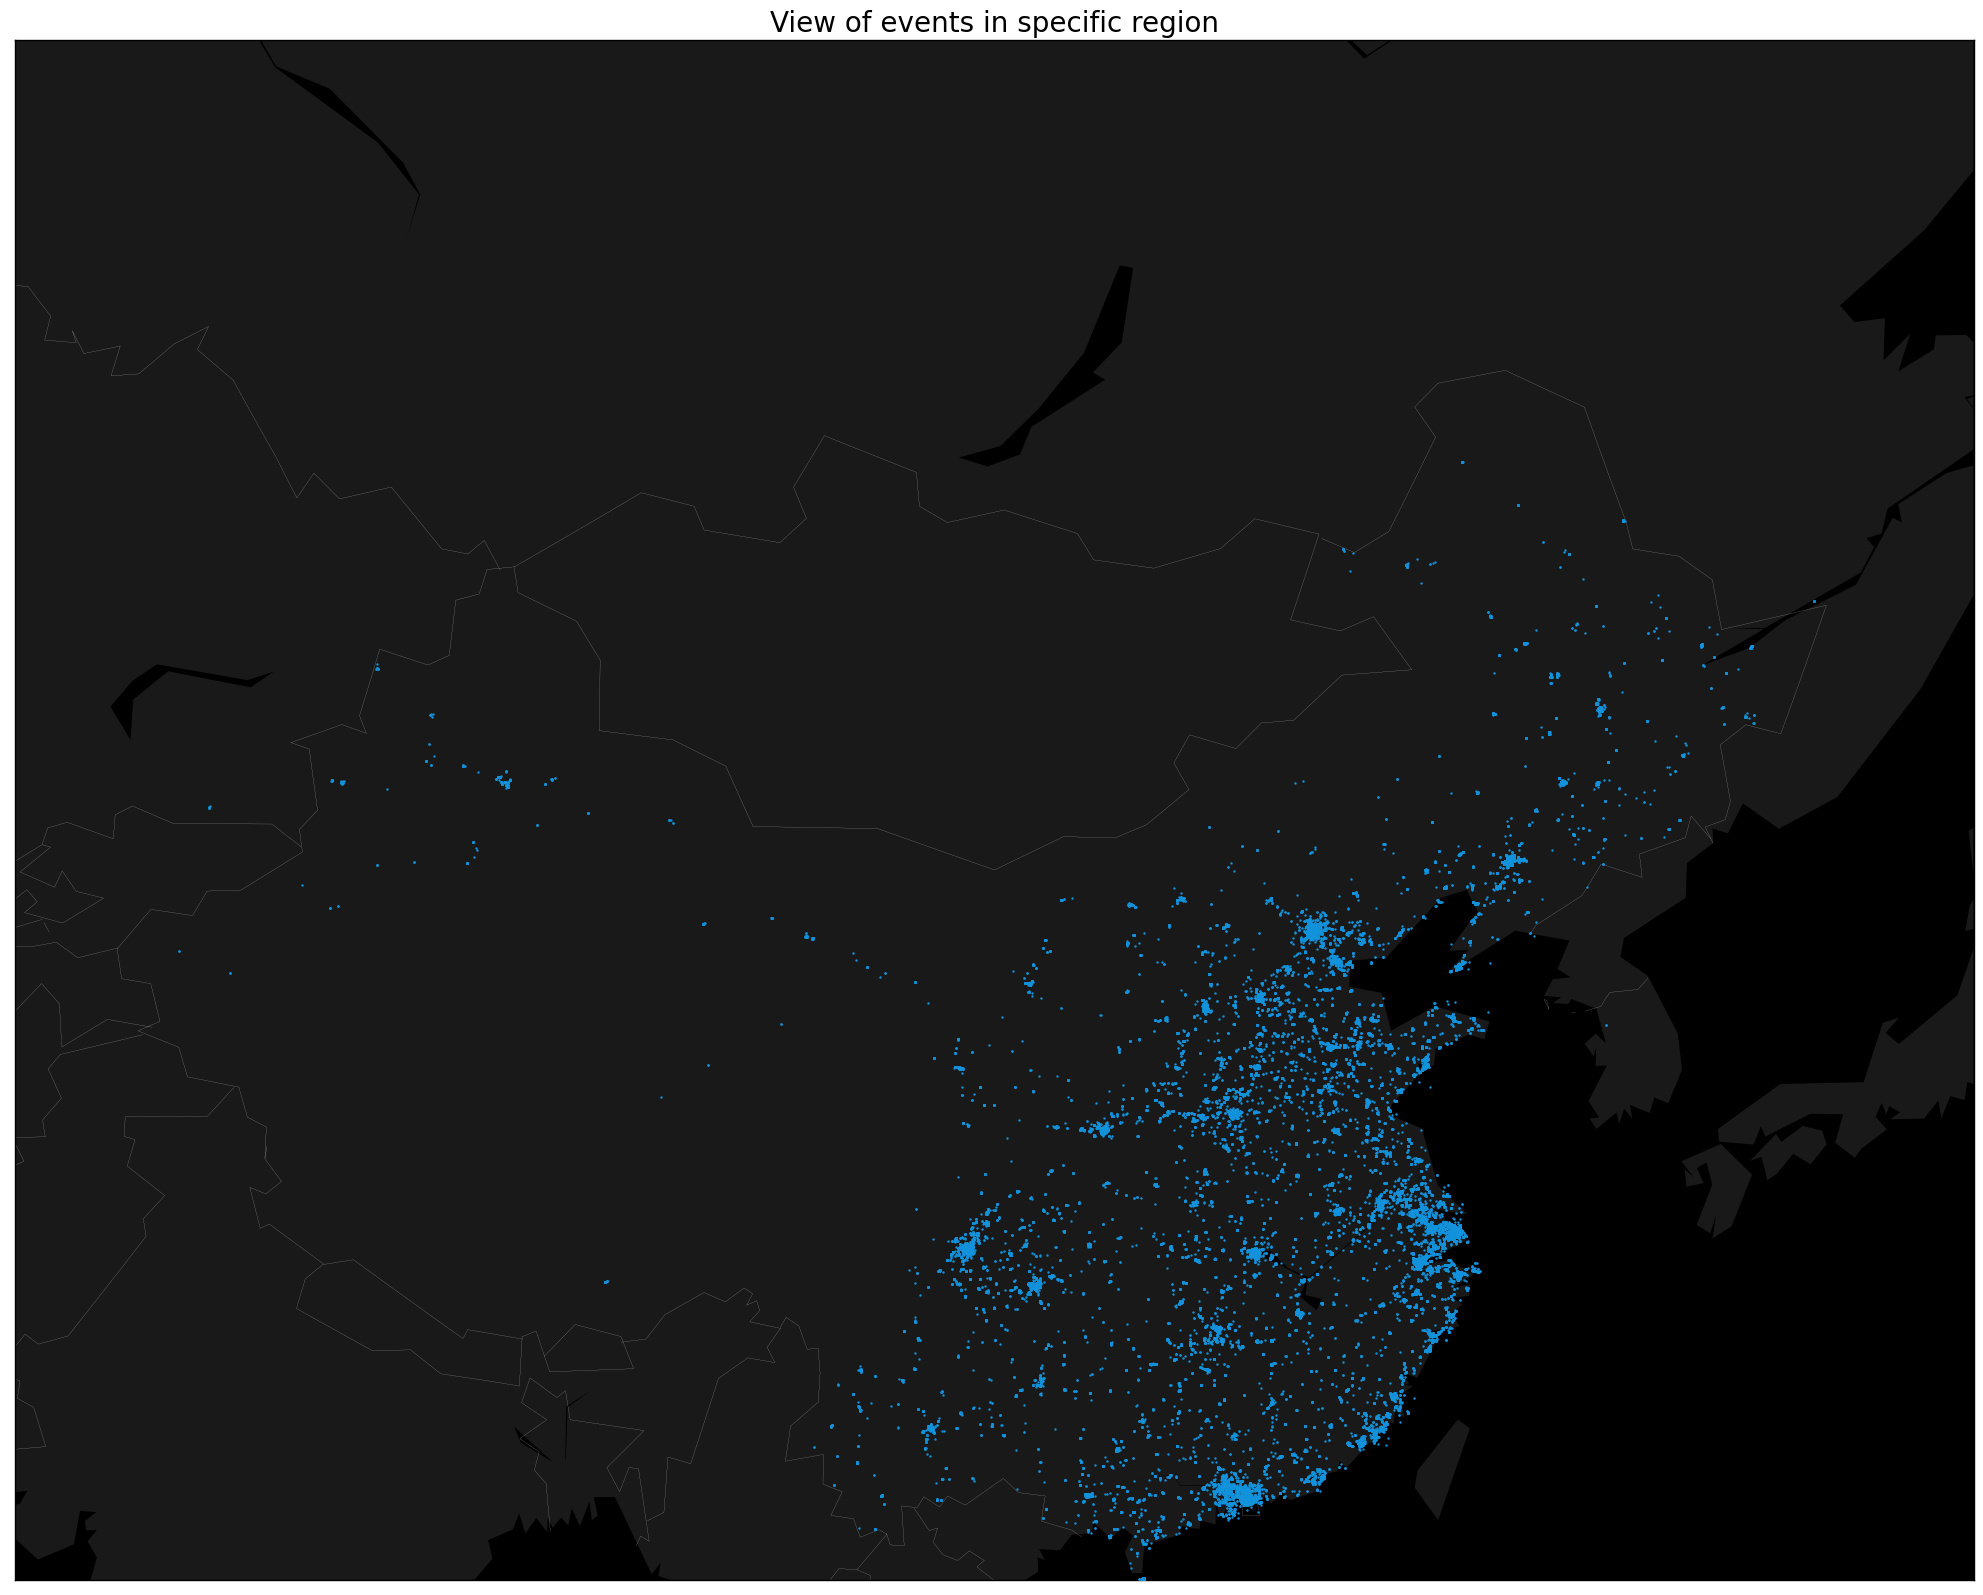

In [84]:
#specific region
plt.figure(2, figsize=(34,20))
plot_geo_data(df_events_sample,70,140,20,60,isSpecific = True)
plt.title("View of events in specific region",fontsize=20)
plt.show()

- In china most of the data points for the events lie on the coast side as indicated by the above graph.

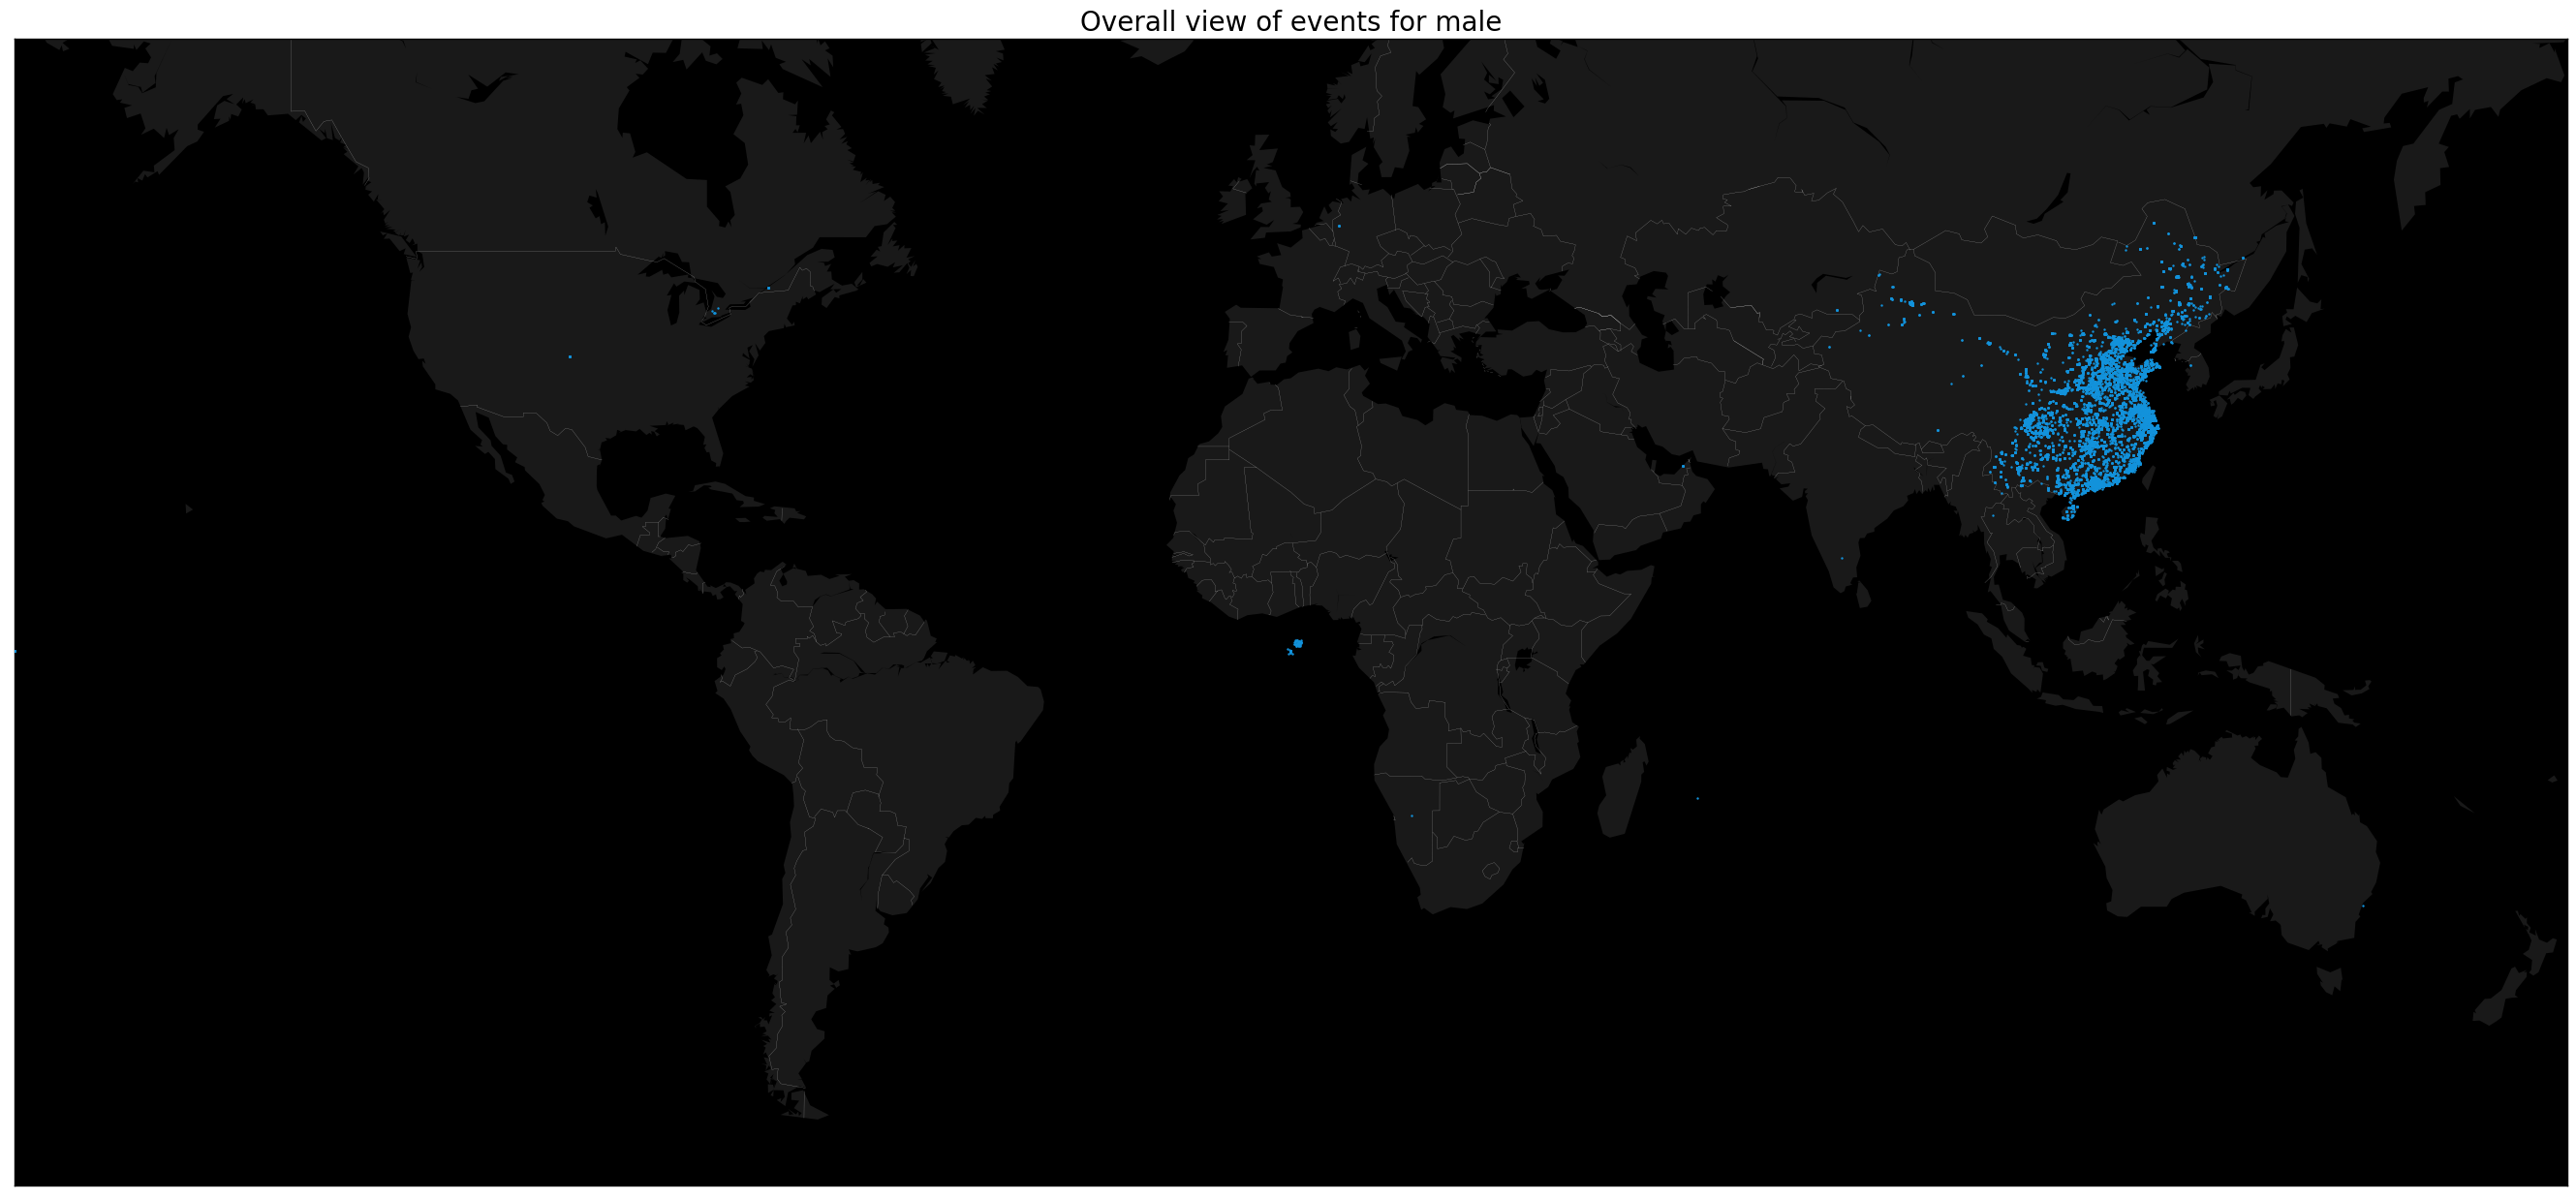

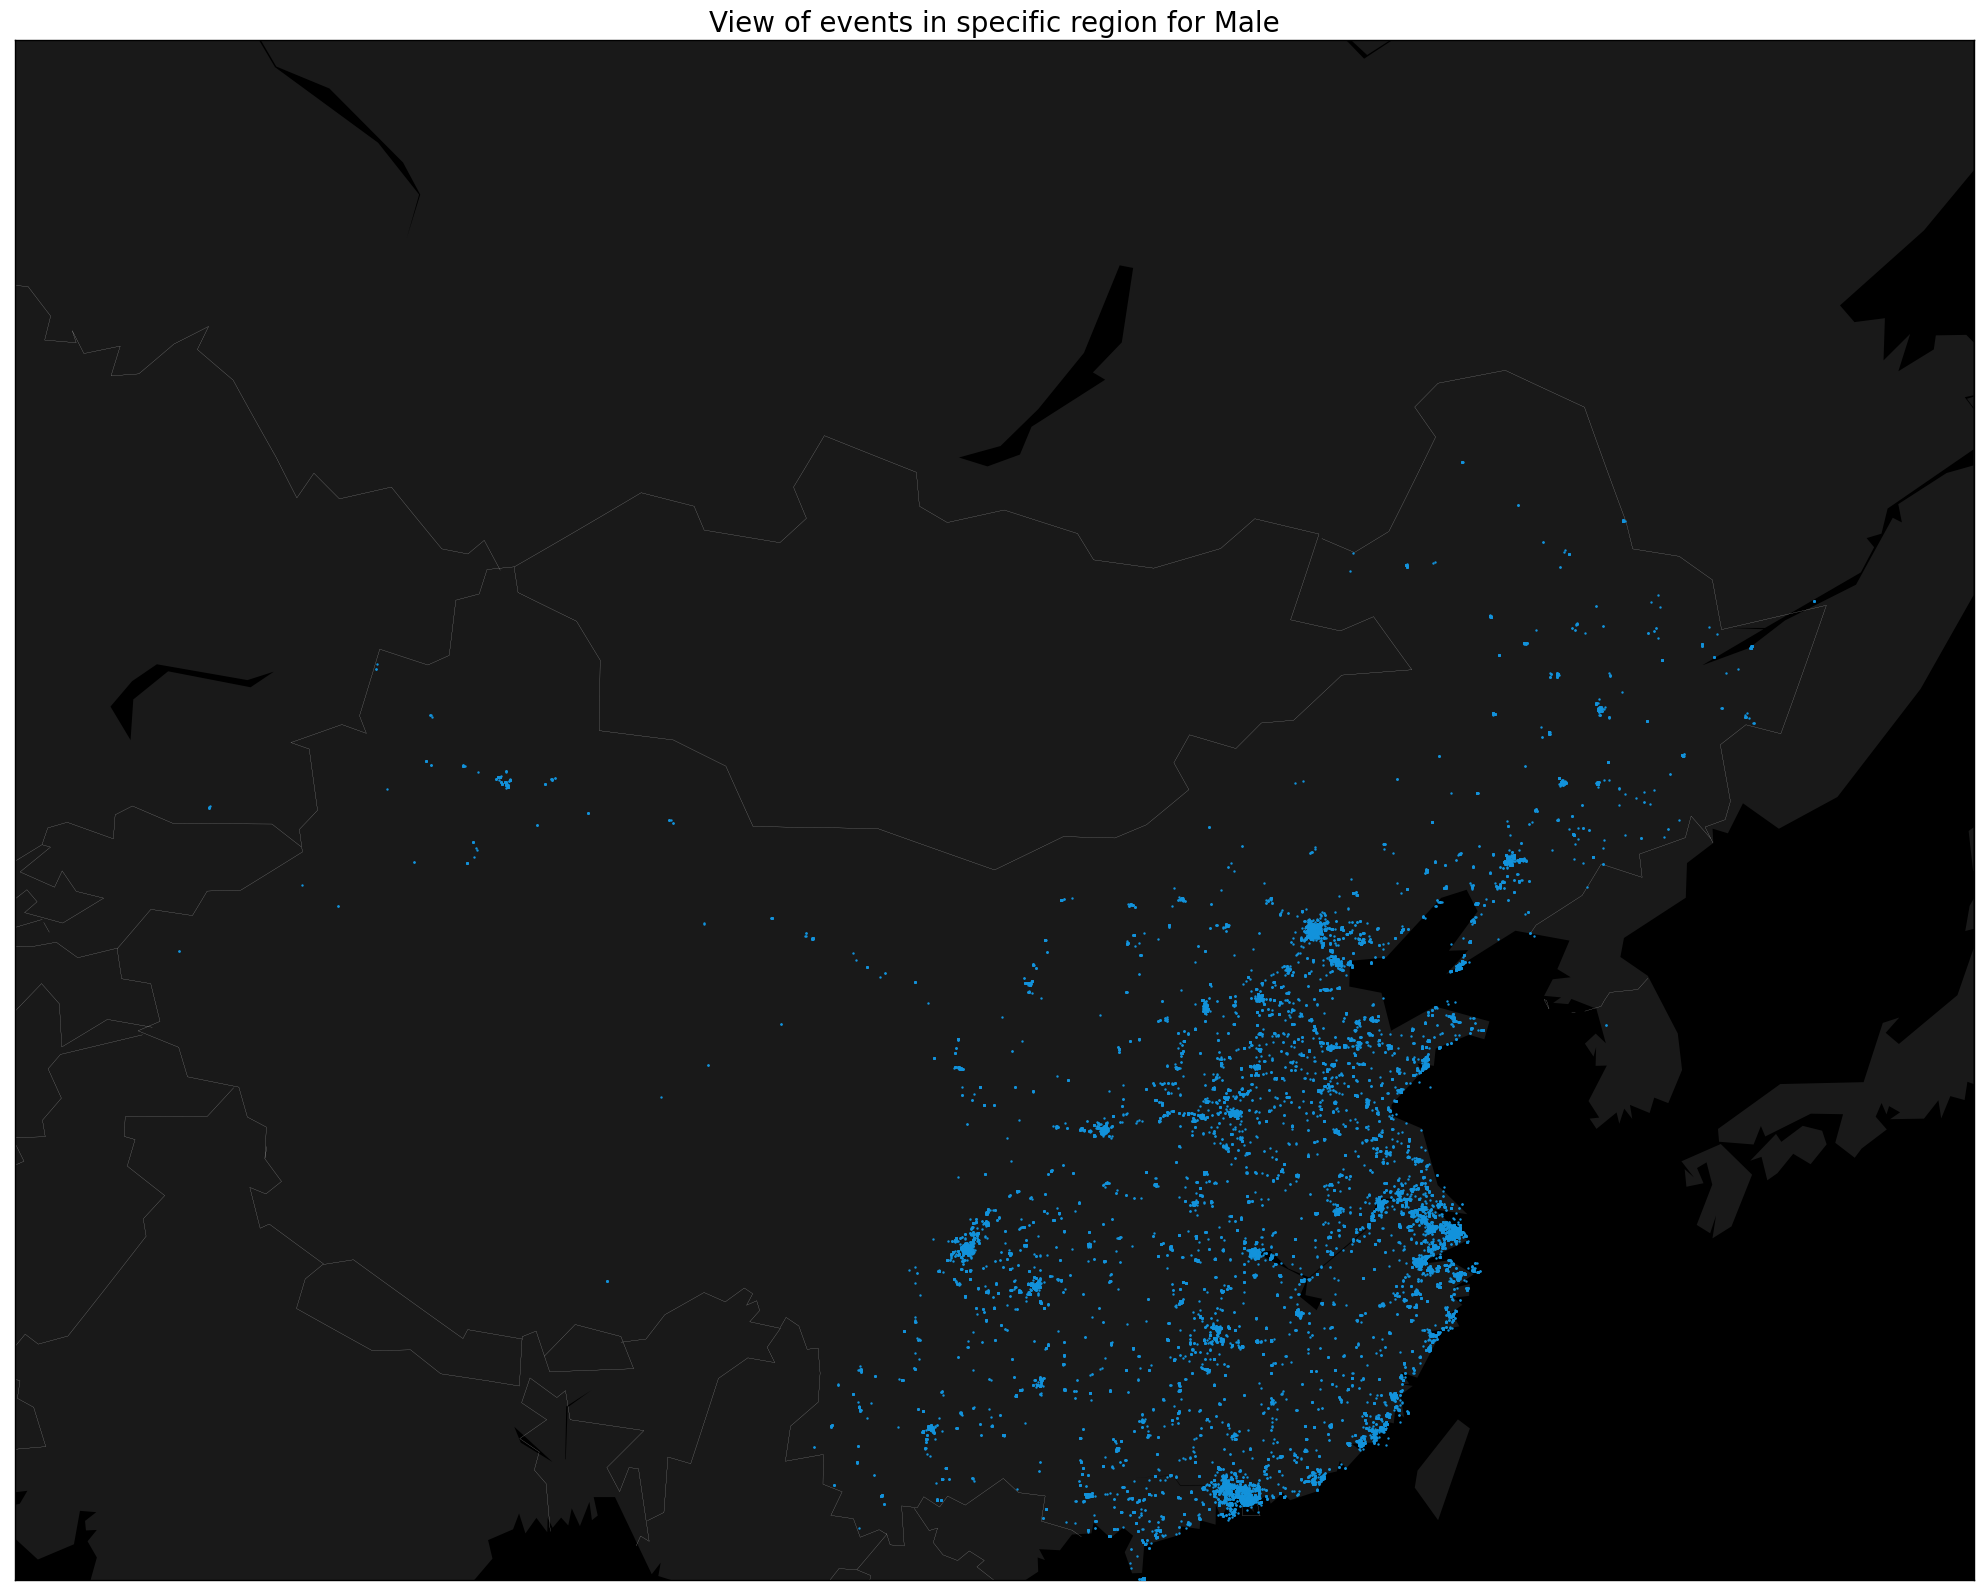

In [85]:
## Visualization for Male
plt.figure(3, figsize=(34,20))
plot_geo_data(df_events_sample,filterBy = 'M',filterByColumn = 'gender')
plt.title("Overall view of events for male",fontsize=20)
plt.show()

#specific region for Males
plt.figure(4, figsize=(34,20))
plot_geo_data(df_events_sample,70,140,20,60,isSpecific = True,filterBy = 'M', filterByColumn = 'gender')
plt.title("View of events in specific region for Male",fontsize=20)
plt.show()


- Data for males is also concentrated mainly on the coast side.

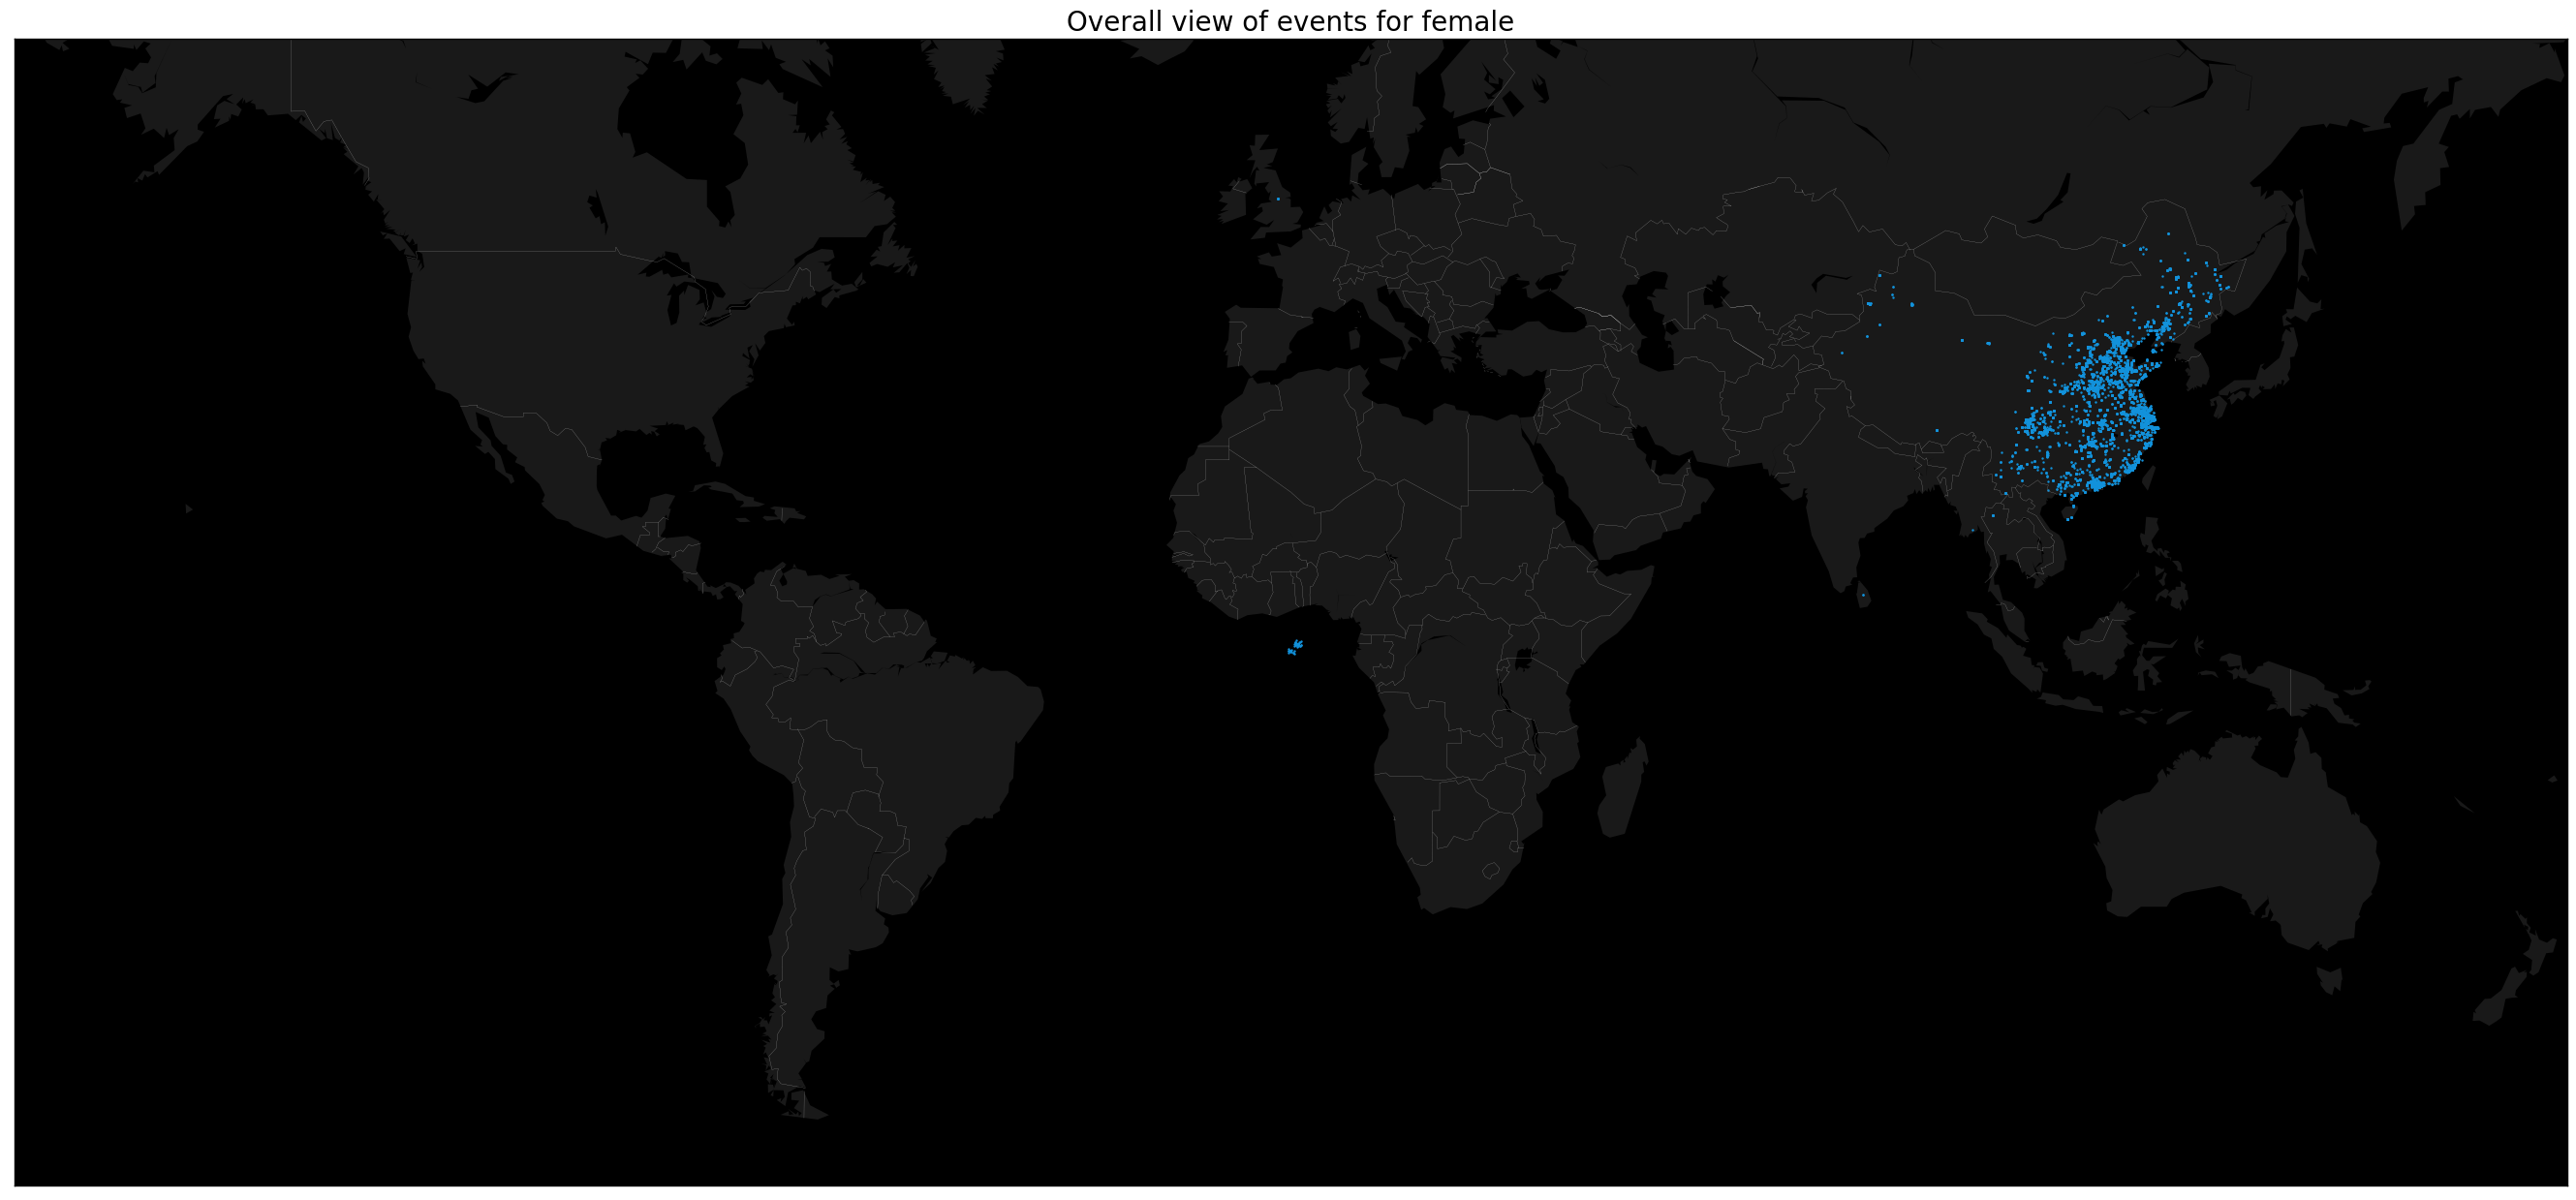

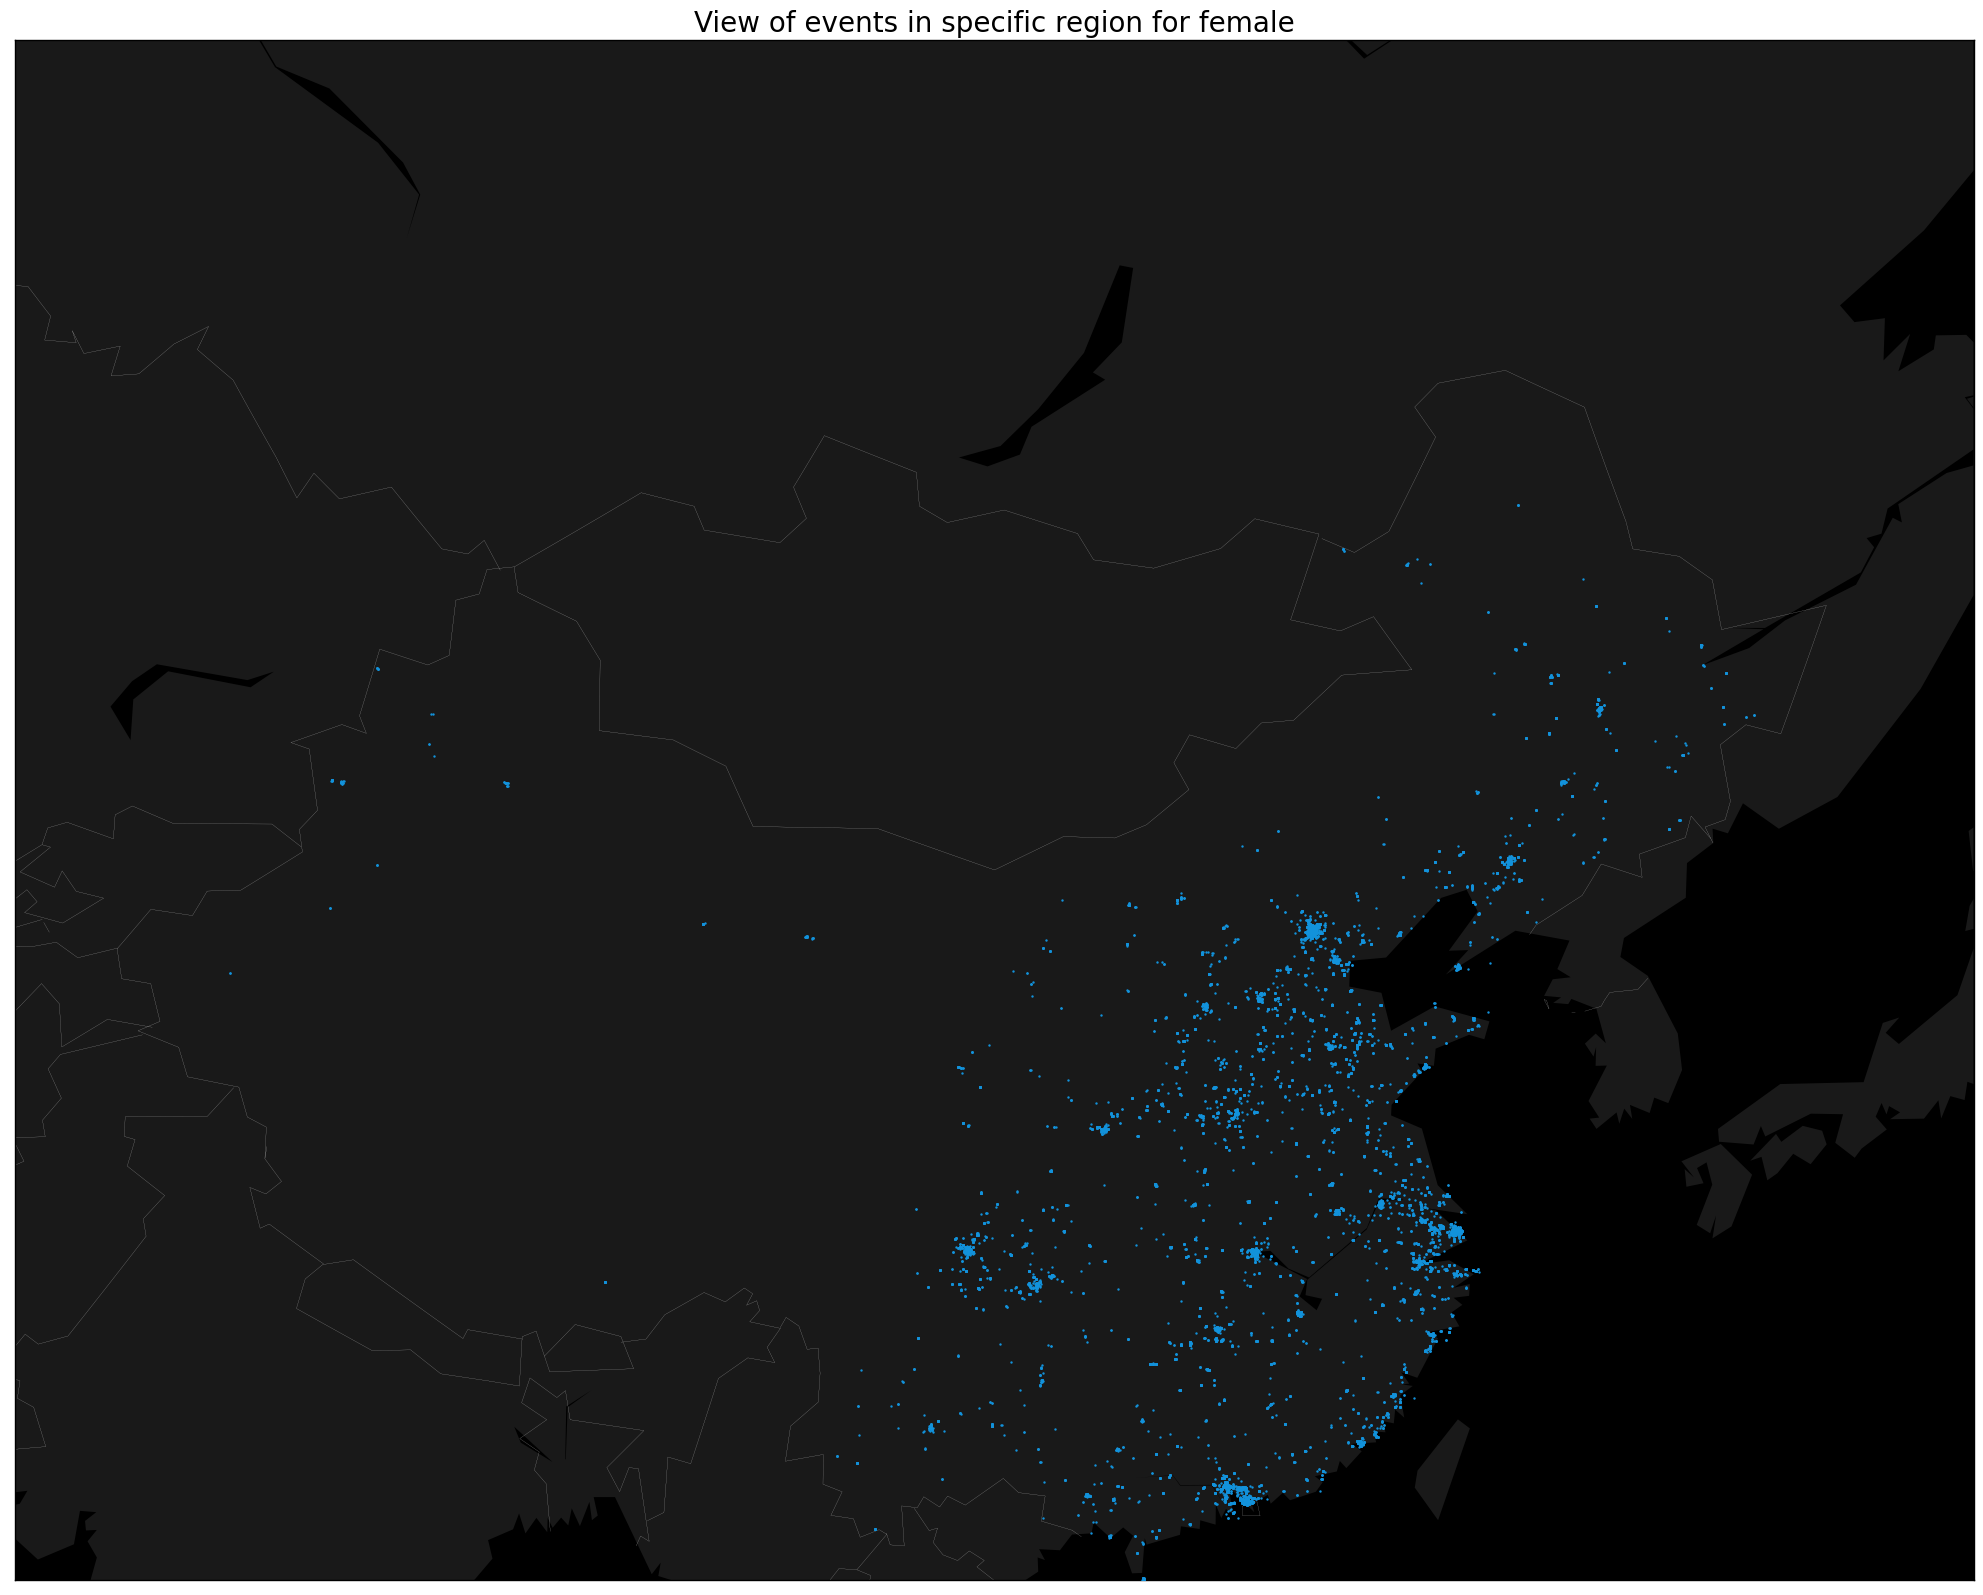

In [86]:
## Visualization for Female

plt.figure(5, figsize=(34,20))
plot_geo_data(df_events_sample,filterBy = 'F',filterByColumn = 'gender')
plt.title("Overall view of events for female",fontsize=20)
plt.show()

#specific region for Feamles
plt.figure(6, figsize=(34,20))
plot_geo_data(df_events_sample,70,140,20,60,isSpecific = True,filterBy = 'F',filterByColumn = 'gender')
plt.title("View of events in specific region for female",fontsize=20)
plt.show()


- In comparison to the geo plot for males we have less number of data points for females.

In [87]:
#Getting the age groups as per problem statement
df_events_sample['group_train_event_age'] = df_events_sample['group_train'].apply(lambda x : x[1:])
df_events_sample['group_train_event_age'].unique()

array(['32+', '25-32', '0-24'], dtype=object)

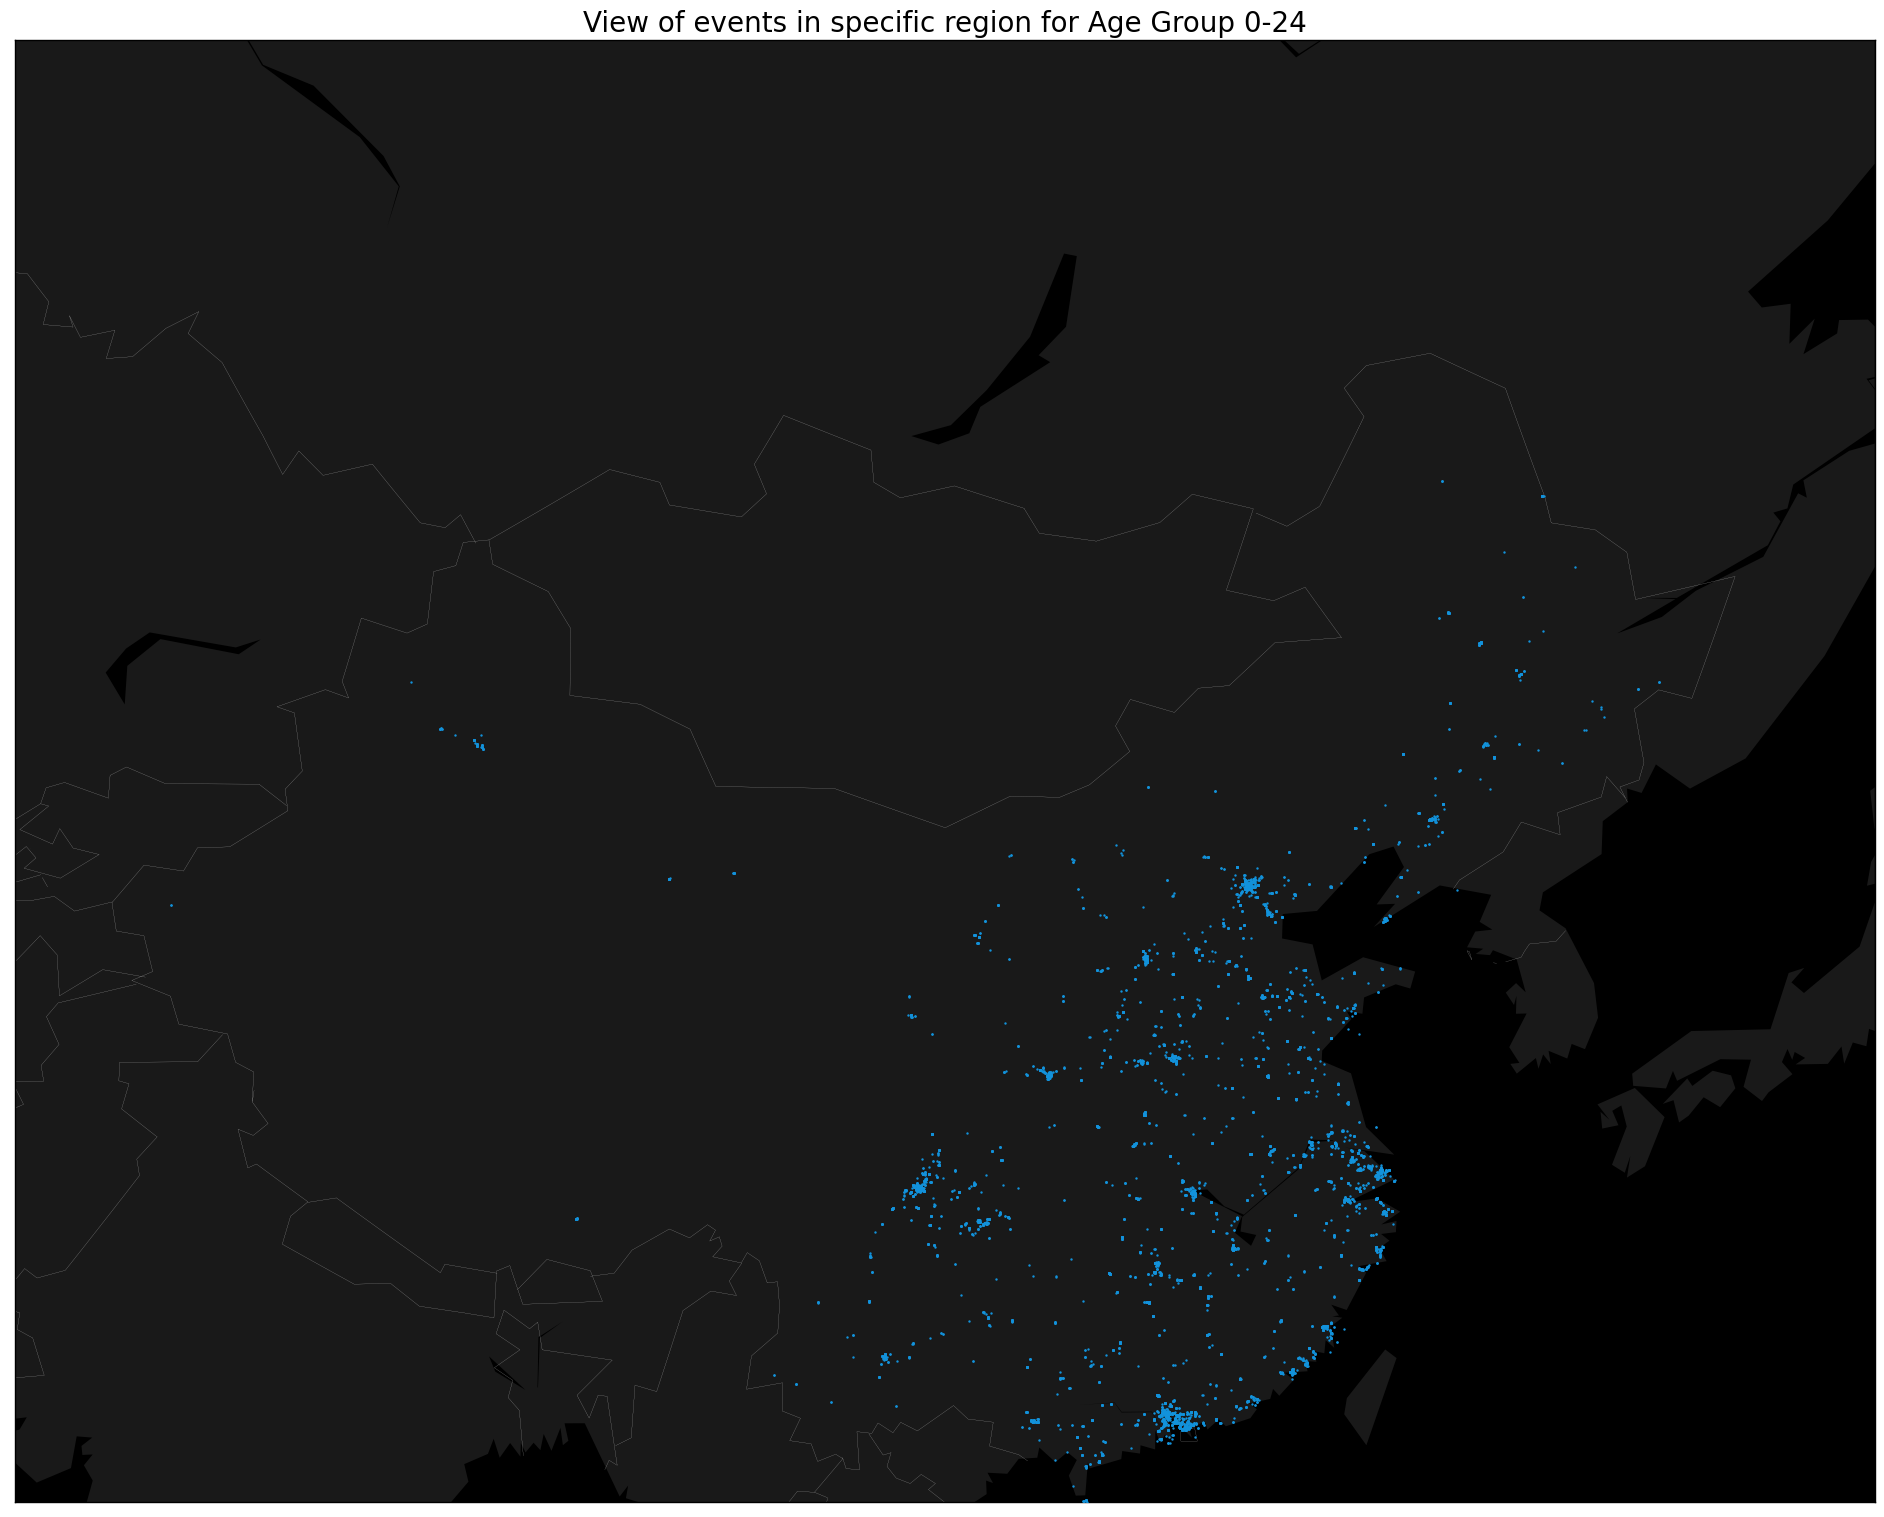

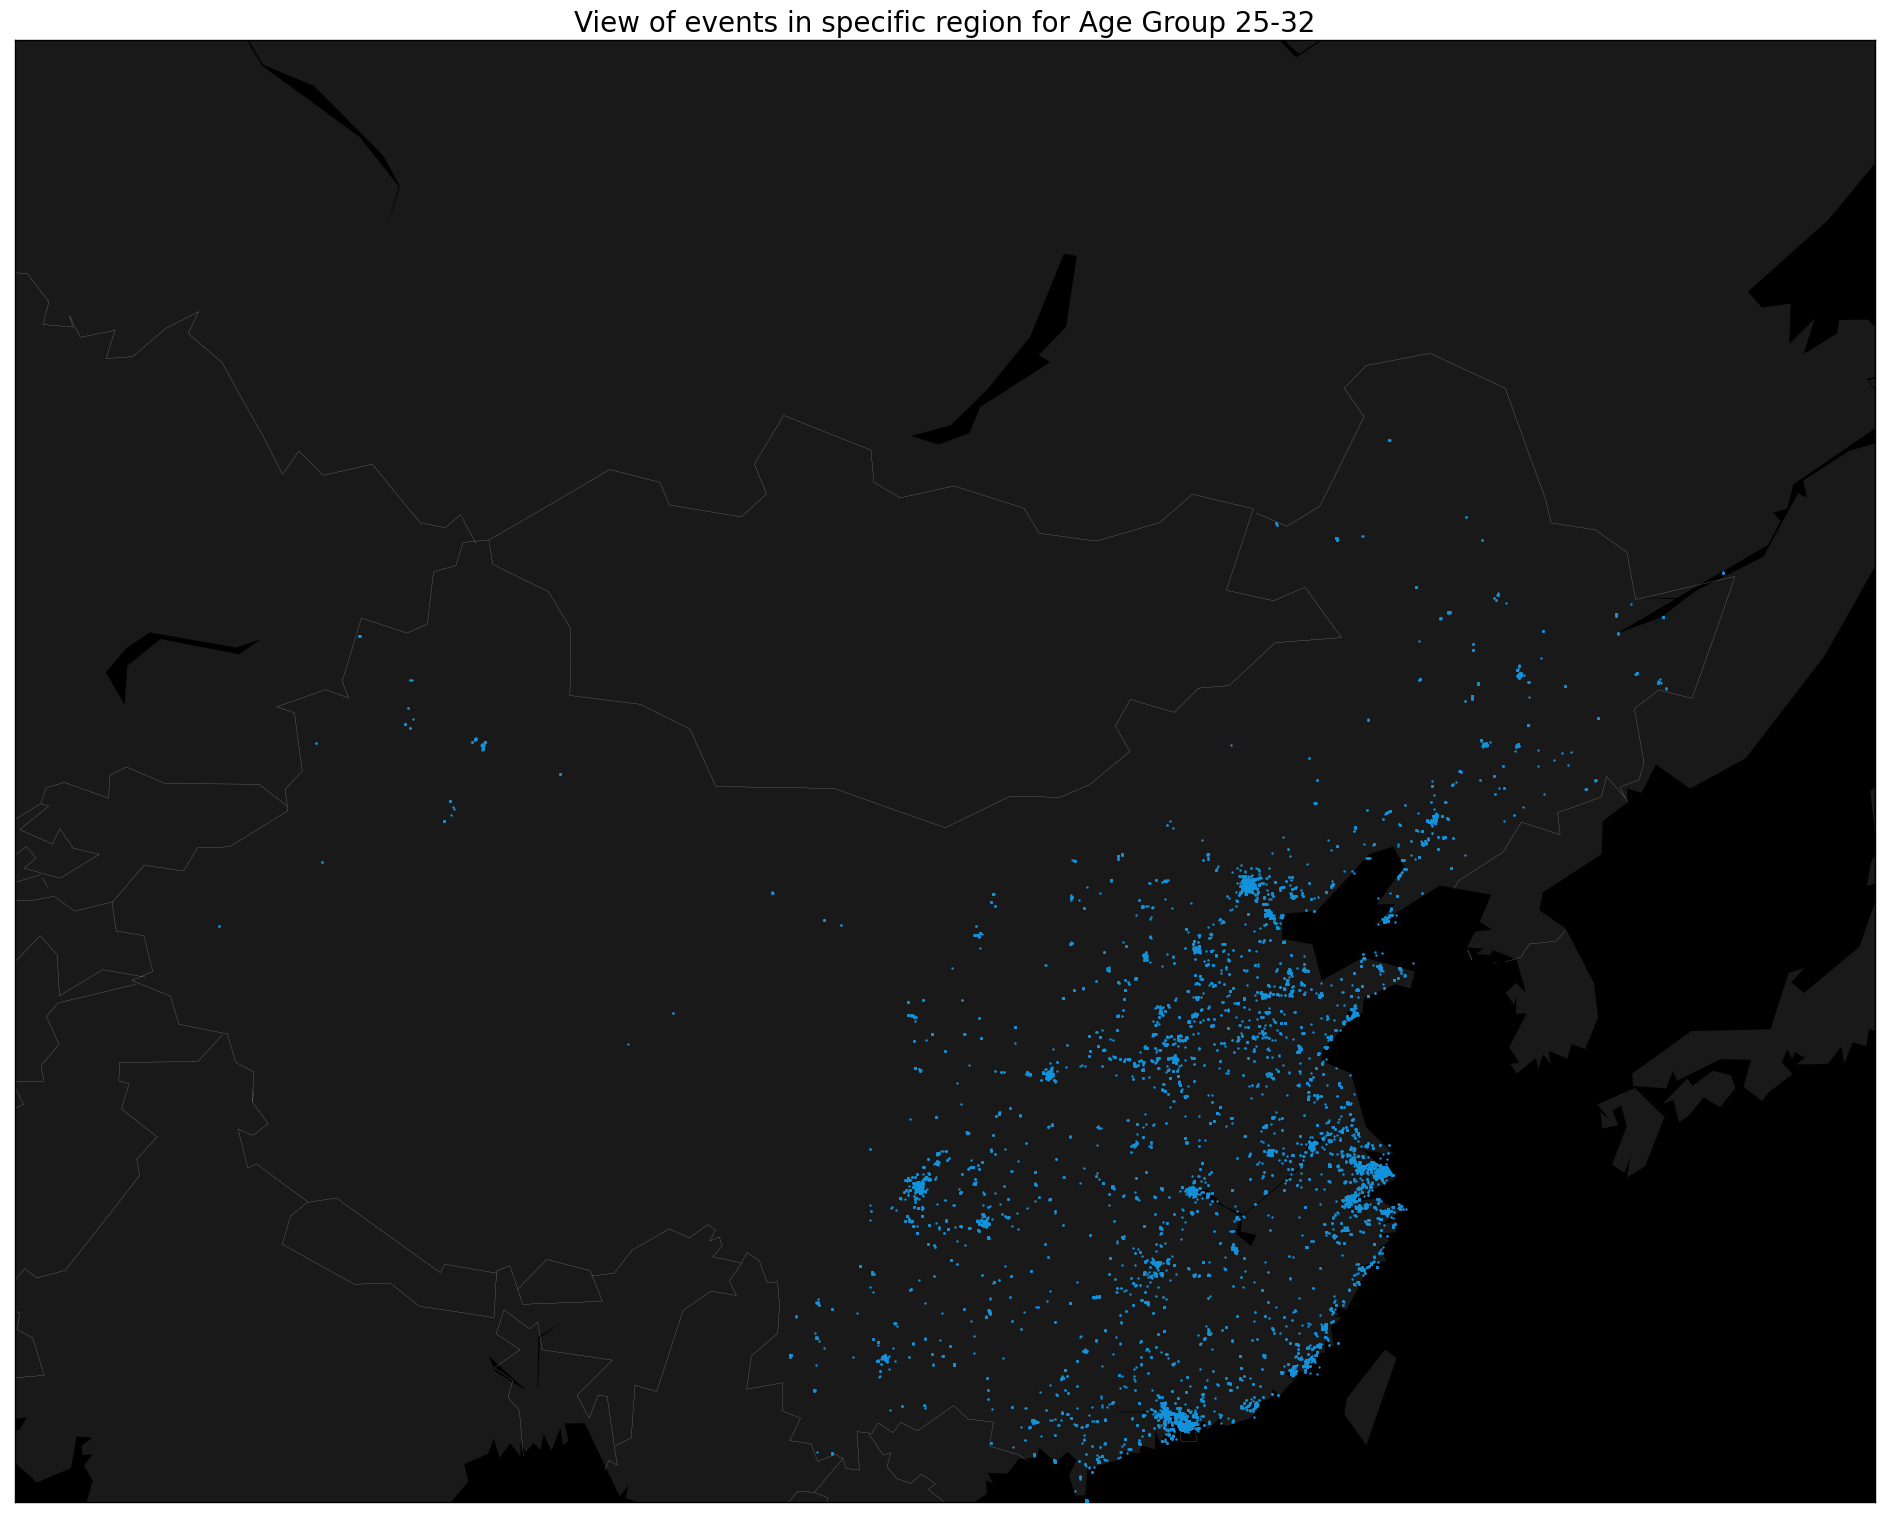

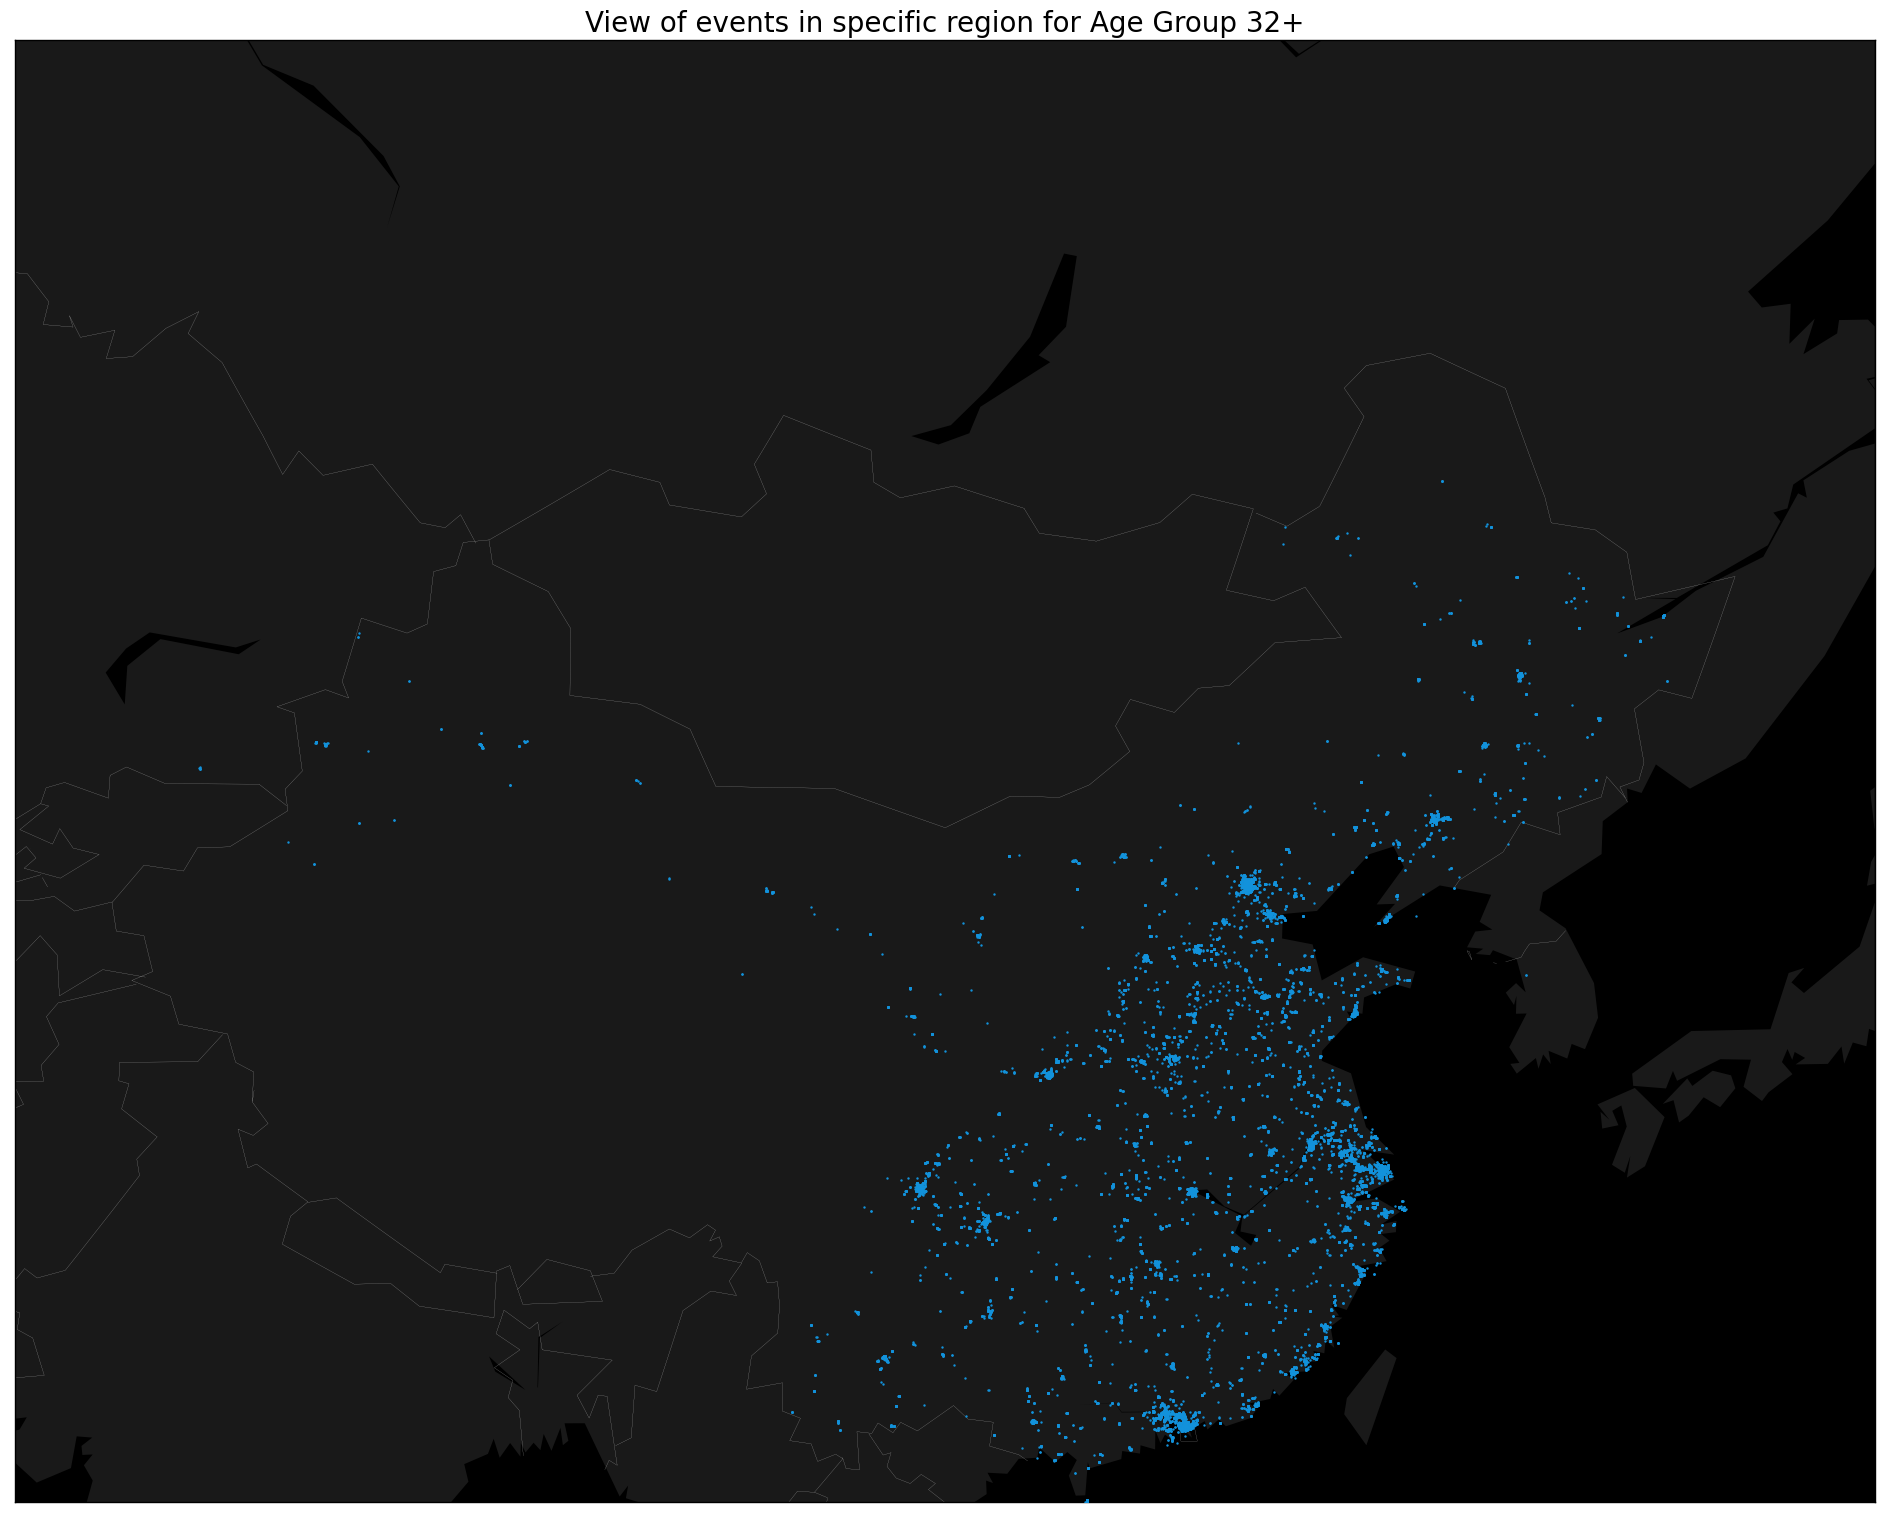

In [88]:
#specific region for 0-24 Age group
plt.figure(7, figsize=(24,20))
plot_geo_data(df_events_sample,70,140,20,60,isSpecific = True,filterBy = '0-24', filterByColumn = 'group_train_event_age')
plt.title("View of events in specific region for Age Group 0-24",fontsize=20)
plt.show()


#specific region for 25-32 Age group
plt.figure(7, figsize=(24,20))
plot_geo_data(df_events_sample,70,140,20,60,isSpecific = True,filterBy = '25-32', filterByColumn = 'group_train_event_age')
plt.title("View of events in specific region for Age Group 25-32",fontsize=20)
plt.show()


#specific region for 32+ Age group
plt.figure(8, figsize=(24,20))
plot_geo_data(df_events_sample,70,140,20,60,isSpecific = True,filterBy = '32+', filterByColumn = 'group_train_event_age')
plt.title("View of events in specific region for Age Group 32+",fontsize=20)
plt.show()




- As seen in above geo plots for age group 25-32 the graph is densely populated with lot of data points suggesting that people in this age group use apps in mobile phones more.
- When comparing age group 0-24 and 32+ it seems there are more clustered points in 32+ geo plot when compared with 0-24 age group.

In [89]:
df_train_mobile.head()

device_id gender  age group_train phone_brand device_model  \
0 -7548291590301750000      M   33        M32+      Huawei     è£è€€3C   
1  6943568600617760000      M   37        M32+      Xiaomi        xnote   
2  5441349705980020000      M   40        M32+        OPPO          R7s   
3 -5393876656119450000      M   33        M32+      Xiaomi         MI 4   
4  4543988487649880000      M   53        M32+     samsung    Galaxy S4   

  age_group  
0     33-45  
1     33-45  
2     33-45  
3     33-45  
4       46+

In [90]:
df_app_events.columns

Index(['event_id', 'app_id', 'is_installed', 'is_active'], dtype='object')

In [91]:
df_train_event.head()

device_id gender  age group_train  event_id       datetimestamp  \
0 -7548291590301750000      M   33        M32+   2369465 2016-05-03 15:55:35   
1 -7548291590301750000      M   33        M32+   1080869 2016-05-03 06:07:16   
2 -7548291590301750000      M   33        M32+   1079338 2016-05-04 03:28:02   
3 -7548291590301750000      M   33        M32+   1078881 2016-05-04 02:53:08   
4 -7548291590301750000      M   33        M32+   1068711 2016-05-03 15:59:35   

   latitude  longitude        Day Hour age_group  
0     33.98     116.79    Tuesday   15     33-45  
1     33.98     116.79    Tuesday    6     33-45  
2     33.98     116.79  Wednesday    3     33-45  
3     33.98     116.79  Wednesday    2     33-45  
4     33.98     116.79    Tuesday   15     33-45

In [92]:
df_app_events.head()

event_id        app_id  is_installed  is_active
0         2  5.927333e+18             1          1
1         2 -5.720079e+18             1          0
2         2 -1.633888e+18             1          0
3         2 -6.531843e+17             1          1
4         2  8.693964e+18             1          1

In [93]:
df_app_events_meta.head()

app_id  label_id         category
0  7.324885e+18       251          Finance
1 -4.494217e+18       251          Finance
2  6.058196e+18       406          unknown
3  6.058196e+18       407  DS_P2P net loan
4  8.694626e+18       406          unknown

In [94]:
#Saving the cleaned data
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\data'
df_train_mobile[['device_id', 'gender', 'age', 'group_train', 'phone_brand','device_model']].to_csv(f'{path}\\train_mobile_brand_after_eda.csv',index=False)
df_train_event[['device_id', 'gender', 'age', 'group_train', 'event_id',
       'datetimestamp', 'latitude', 'longitude', 'Day', 'Hour']].to_csv(f'{path}\\train_event_data_after_eda.csv',index=False)
df_app_events.to_csv(f'{path}\\app_events_after_eda.csv',index=False)
df_app_events_meta.to_csv(f'{path}\\app_events_meta_data_after_eda.csv',index=False)